### Objective: To extract descriptors from MPK190 derived antibodies. 

THis is using Mutations provided by Kevin using Elisa data. 

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from pathlib import Path
import matplotlib.pyplot as plt
import nglview as nv
from Bio.SeqUtils import seq3
from tqdm.notebook import tqdm
from pdbfixer import PDBFixer
from openmm.app import PDBFile

from developability.utils import ls
from developability.pdb_tools import fix_antibody, correct_oxt, extract_fv_from_pdb, extract_sequence_from_pdb
from developability.pipeline import run_processing_pipeline


DATAPATH  = "/Users/ChristopherRivera/Documents/DataResults/MPK190" 
data_path = Path(DATAPATH)
%config InlineBackend.figure_format='retina'



In [2]:
ls(data_path, True)

['MPK190_mutations_v13',
 'MPK190_HeparinBindingDataSet2.xlsx',
 'MPK190.fv_only.pdb',
 'predicted_pdbs',
 '.DS_Store',
 'MPK190.pdb',
 'predicted_pdbs_for_HeparinRTT',
 'VH2.csv',
 'mutations',
 'MPK190-v13-metadata.pq',
 'HeparinBinding.csv',
 'HeparinBindingDataSet2.csv',
 'VL2.csv',
 'MPK190_HeparinBinding.xlsx',
 'VL.csv',
 'MPK190-v1.3-rFab_sequence.fa',
 'MPK190v1.3_Complex_newestCryoEM_Modified.pdb',
 'MPK190v1.3_Complex_newestCryoEM.pdb',
 'IC50 MPK190-v1.3 variants round2 sorted.xlsx',
 'mutations_data.parquet',
 'VH.csv',
 'MPK190-v13.csv']

In [3]:
heparin_df = pd.read_csv(data_path/'HeparinBinding.csv', header = None)
vl_df = pd.read_csv(data_path/'VL.csv')
vh_df = pd.read_csv(data_path/'VH.csv', header = None, index_col=0)
parent_pdb = data_path/'MPK190v1.3_Complex_newestCryoEM.pdb'
heparin_df.head()

0      1      2      3      4      5      6      7     8     9   ...  \
0  1.000  0.746  0.652  1.023  0.570  0.557  0.604  0.591  0.71  0.72  ...   
1  0.611  0.625  0.624  0.633  0.631  0.597    NaN    NaN   NaN   NaN  ...   
2  1.099  1.562  1.182  1.087  1.027  1.098    NaN    NaN   NaN   NaN  ...   
3  0.515  0.573  0.575  0.541  0.592  0.605    NaN    NaN   NaN   NaN  ...   
4  1.412  0.671  0.528  0.578  0.689  0.703    NaN    NaN   NaN   NaN  ...   

      17    18     19     20     21     22     23     24     25     26  
0  0.602  0.48  0.609  0.777  0.599  0.426  0.532  0.794  0.566  0.612  
1    NaN   NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN  
2    NaN   NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN  
3    NaN   NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN  
4    NaN   NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN  

[5 rows x 27 columns]

In [4]:
def compute_vl_mut_map(vl_df): 
    m, n = vl_df.shape
    vl_df = vl_df.fillna('').copy()
    vl_mut_map = {0:''}
    parental= vl_df.columns
    for row in range(m): 
        vl_mut_map.setdefault(row+1, [])
        for col in range(n): 
            if vl_df.iloc[row, col]: 
                
                vl_mut_map[row+1].append([parental[col][0],int(parental[col][1:]), vl_df.iloc[row,col]])

    return vl_mut_map


def compute_vh_mut_map(vh_df):
    return compute_vl_mut_map(vh_df.T)

def create_heparin_table(heparin_df, vl_map, vh_map): 
    m, n = heparin_df.shape
    heparin_df = heparin_df.fillna(0).copy()

    records = []
    for i in range(m):
        for j in range(n):
            if i==0 and j==0: 
                records.append(['', '',1.0])
            else: 
                if heparin_df.iloc[i, j]:
                    records.append([vl_map[i], vh_map[j], heparin_df.iloc[i,j]])
    return pd.DataFrame.from_records(records, columns=['Vl mutations', 'Vh mutations', 'heparin binding'])


def show_struct(pdb_file, size = 500, gui = False): 
    print(pdb_file.name)
    view = nv.show_structure_file(str(pdb_file))
    view._remote_call('setSize', target='Widget', args=['',f'{size}px'])
    view.render_image(factor = 2)
    view.display(gui)
    return view



#### Generate a heparin table

In [5]:
vl_map = compute_vl_mut_map(vl_df)
vh_map =compute_vh_mut_map(vh_df)

heparin_table = create_heparin_table(heparin_df, vl_map, vh_map)        
heparin_table

Vl mutations  Vh mutations  \
0                                                                    
1                                                      [[V, 2, D]]   
2                                                      [[Q, 3, E]]   
3                                                      [[V, 5, E]]   
4                                                     [[K, 13, Q]]   
..                                               ...           ...   
57              [[R, 17, E], [G, 43, E], [A, 76, S]]                 
58              [[R, 17, E], [S, 69, E], [A, 76, S]]                 
59              [[R, 17, E], [G, 43, E], [S, 69, E]]                 
60              [[G, 43, E], [S, 69, E], [A, 76, S]]                 
61  [[R, 17, E], [G, 43, E], [S, 69, E], [A, 76, S]]                 

    heparin binding  
0             1.000  
1             0.746  
2             0.652  
3             1.023  
4             0.570  
..              ...  
57            1.741  
58            0.614  
59            1.789  
60            1.055  
61            1.240  

[62 rows x 3 columns]

### Look at the parental structure

In [6]:
show_struct(parent_pdb, 600, True)

MPK190v1.3_Complex_newestCryoEM.pdb


ThemeManager()

NGLWidget(gui_style='ngl')

In [7]:
output_path= data_path/'mutations'
if not output_path.exists():
    output_path.mkdir()

### Remove unwanted chains and replace internal residues as needed for parent. 
Below, I keep only the H and L chains. 

In [8]:
output_file_name = 'MPK190.pdb'
# fix the antibody
fixer = fix_antibody(parent_pdb, ['H', 'L'], output_file_name, output_path=None, keep_ids=False, fix_internal_residues_only=True)

# correct OXT
fixed_parent_pdb = data_path/output_file_name
new_parent_pdb = data_path/'mutations'/output_file_name
correct_oxt(fixer, new_parent_pdb)
extract_fv_from_pdb(new_parent_pdb,new_parent_pdb)
show_struct(new_parent_pdb, 600, True)

The number of OXT atoms is 2.
The number of OXT->O is 1.
MPK190.pdb


NGLWidget(gui_style='ngl')

#### Functions for mutating the protein 

In [9]:
def mutate_protein(pdb, mutations, output_path=None, output_filename=None, keep_ids=True, transform_mutants=True):
    """Uses PDBFixer to mutate antibody, save the file

    Args:
        pdb (str|path): path to pdb file
        mutations (dict): dict with keys for chain and values of list of mutations
        output_filename (str, optional): name of file. Defaults to None.  
        output_path (str|Path, optional):output path. Defaults to None.
        keep_ids (bool, optional): whether to keep original chain ids and numbering. Defaults to True.
        transform_mutants (bool, optional): If True, transform 1 letter code to 3 letter code. Defaults to True.

    Returns:
        _type_: _description_
    """

    fixer = PDBFixer(str(pdb))
    for chain, muts in mutations.items(): 
        if transform_mutants:
            fixer.applyMutations(transform_mutant_tuples(muts), chain)
        else:
            fixer.applyMutations(muts, chain)
    
    if not output_filename: 
        name = Path(pdb).name.split('.')[0]
        for chain, muts in mutations.items(): 
            if muts: 
                muts = [''.join(str(c) for c in m) for m in muts]
                name += '-' + chain + '-' + '-'.join(muts)
        output_file_name = name + '.pdb'

    if not output_path:
        output_path = Path(pdb).parent
    
    output = output_path /output_file_name
    PDBFile.writeFile(fixer.topology, fixer.positions, open(str(output), 'w'), keepIds = keep_ids)
    return output

def transform_mutant_tuple(mutant):
    return f'{seq3(mutant[0]).upper()}-{int(mutant[1])}-{seq3(mutant[2]).upper()}'

def transform_mutant_tuples(muts): 
    return [transform_mutant_tuple(mut) for mut in muts]
     
def generate_mutations_dict(row):
    mutations = {'L': row['Vl mutations'],
                 'H': row['Vh mutations']
                 }
    return mutations


In [10]:
parent_pdb = data_path/'mutations'/output_file_name 
row = heparin_table.loc[1]
mutations = generate_mutations_dict(row)
pdb_out = mutate_protein(parent_pdb, mutations, data_path/'mutations')
show_struct(pdb_out)



MPK190-H-V2D.pdb


NGLWidget()

In [11]:
heparin_table

Vl mutations  Vh mutations  \
0                                                                    
1                                                      [[V, 2, D]]   
2                                                      [[Q, 3, E]]   
3                                                      [[V, 5, E]]   
4                                                     [[K, 13, Q]]   
..                                               ...           ...   
57              [[R, 17, E], [G, 43, E], [A, 76, S]]                 
58              [[R, 17, E], [S, 69, E], [A, 76, S]]                 
59              [[R, 17, E], [G, 43, E], [S, 69, E]]                 
60              [[G, 43, E], [S, 69, E], [A, 76, S]]                 
61  [[R, 17, E], [G, 43, E], [S, 69, E], [A, 76, S]]                 

    heparin binding  
0             1.000  
1             0.746  
2             0.652  
3             1.023  
4             0.570  
..              ...  
57            1.741  
58            0.614  
59            1.789  
60            1.055  
61            1.240  

[62 rows x 3 columns]

In [12]:
descriptors = []
base_output_path = data_path/'mutations'
descriptors_fname = data_path/'MPK190_antibodies_sheet1_descriptors.pq'

if not descriptors_fname.exists():
    for i, row in tqdm(enumerate(heparin_table.iterrows()),total =len(heparin_table)):
        
        if i==0: 
            input_pdb=parent_pdb

        else:    
            mutations=generate_mutations_dict(row[1])
            mutant_pdb = mutate_protein(parent_pdb, mutations, data_path/'mutations')
            input_pdb = mutant_pdb

        output_path = name = input_pdb.name.split('.')[0]
        output_path = base_output_path/ f'{name}_output'
        
        descriptors.append(run_processing_pipeline(input_pdb=input_pdb, output_path=output_path))

    descriptors_df = pd.concat(descriptors)
    descriptors_df['heparin_binding' ]=heparin_table['heparin binding'].values
    descriptors_df.to_parquet(descriptors_fname)
else: 
    descriptors_df = pd.read_parquet(descriptors_fname)



  0%|          | 0/62 [00:00<?, ?it/s]

Starting pdb4amber with /Users/ChristopherRivera/Documents/DataResults/MPK190/mutations/MPK190.pdb. 

2023-11-03 22:58:59,388 [MainThread  ] [INFO ]  Executing biobb_amber.pdb4amber.pdb4amber_run Version: 4.1.0
2023-11-03 22:58:59,390 [MainThread  ] [INFO ]  Copy: /Users/ChristopherRivera/Documents/DataResults/MPK190/mutations/MPK190.pdb to /Users/ChristopherRivera/Projects/developability/Notebooks/ee2f819f-3390-4ae1-a7da-ecd9e83b40b3
2023-11-03 22:58:59,391 [MainThread  ] [INFO ]  Creating e6a9884e-d174-4074-80a8-672a2e7798b5 temporary folder
2023-11-03 22:58:59,391 [MainThread  ] [INFO ]  pdb4amber -i /Users/ChristopherRivera/Projects/developability/Notebooks/ee2f819f-3390-4ae1-a7da-ecd9e83b40b3/MPK190.pdb -o /Users/ChristopherRivera/Projects/developability/Notebooks/ee2f819f-3390-4ae1-a7da-ecd9e83b40b3/pdb4amber.pdb -y 

2023-11-03 22:58:59,901 [MainThread  ] [INFO ]  Exit code 0

2023-11-03 22:58:59,902 [MainThread  ] [INFO ]  
Summary of pdb4amber for: /Users/ChristopherRivera/Pro

In [13]:
!open {base_output_path}

In [14]:
average_zero = (descriptors_df==0).mean()
cols = [col for col in average_zero.index if average_zero.loc[col]<0.75]
non_zero_descriptors = descriptors_df[cols]
non_zero_descriptors.shape



(62, 68)

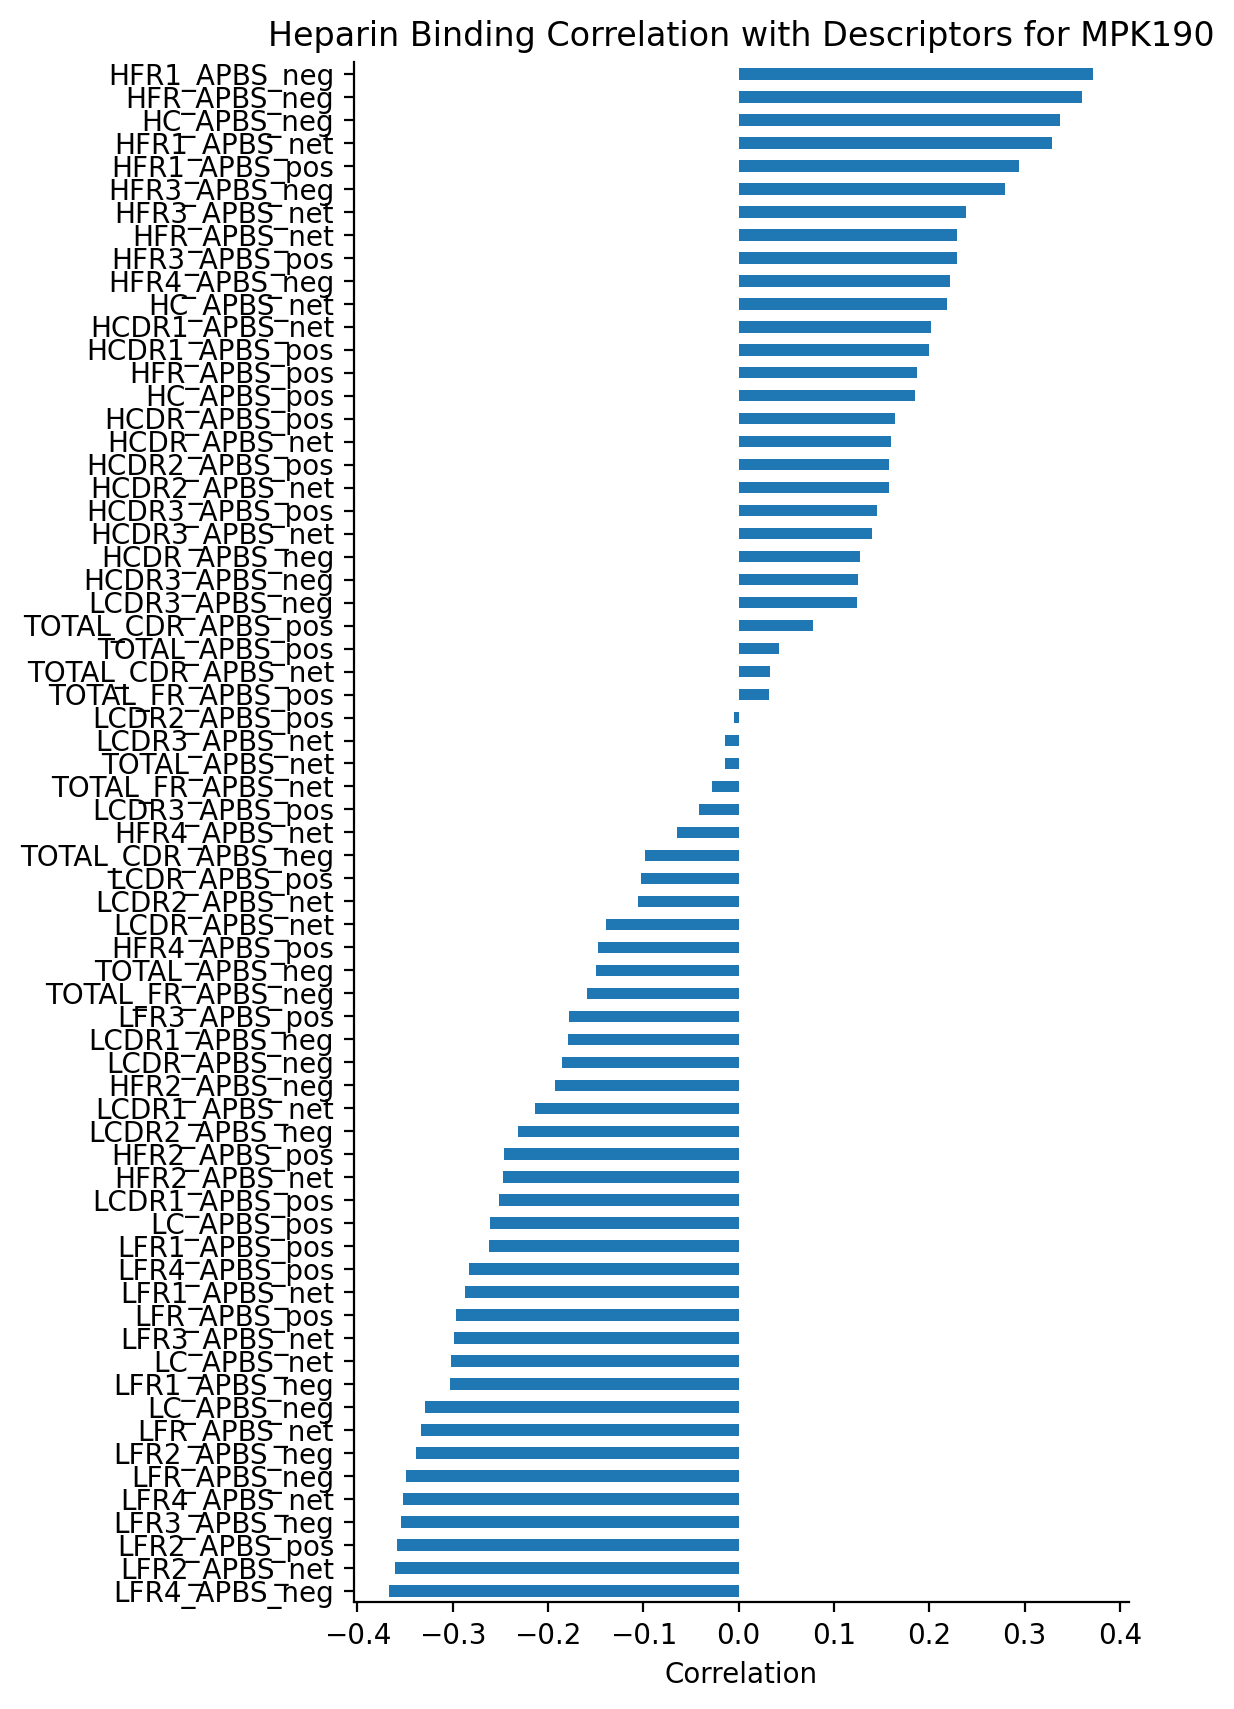

In [15]:
corr = non_zero_descriptors.corr()
heparin_corr =corr.loc['heparin_binding'].sort_values().iloc[:-1]
ax= heparin_corr.plot(kind='barh', figsize = (5,10))
ax.set(xlabel = 'Correlation', title = 'Heparin Binding Correlation with Descriptors for MPK190')
sns.despine()

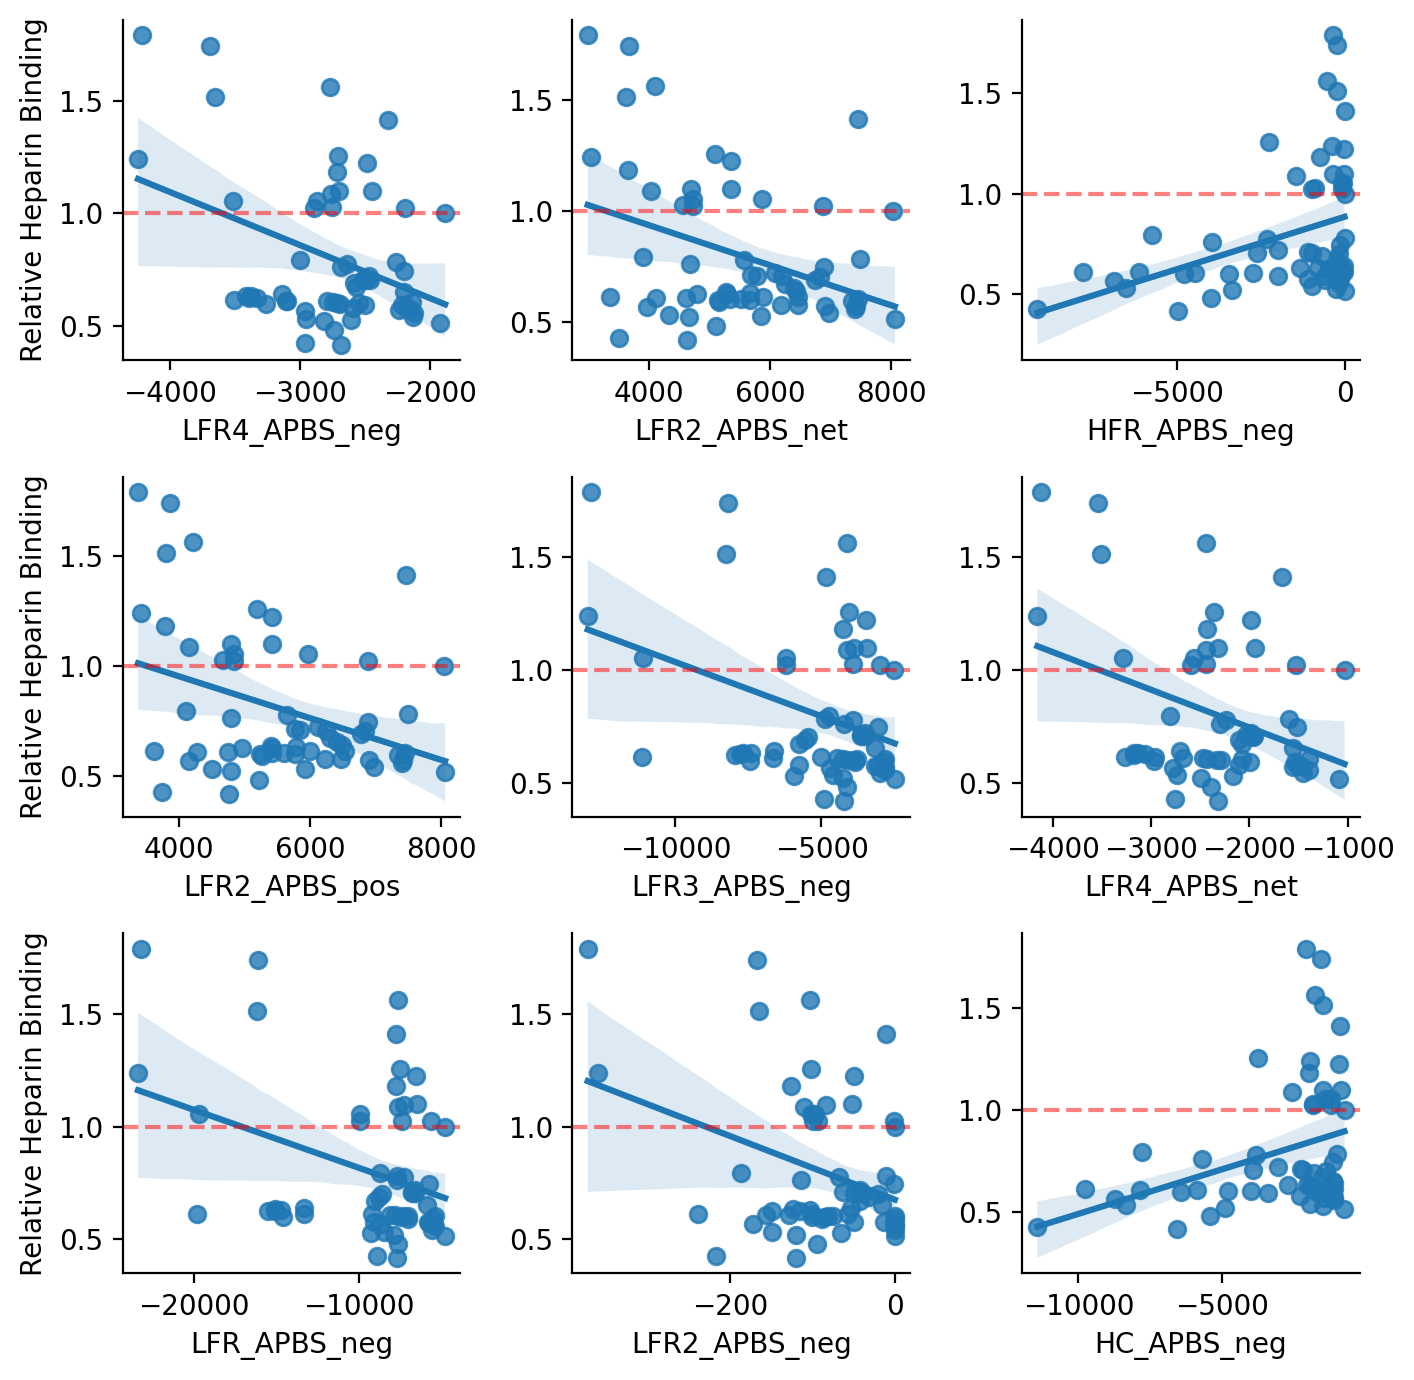

In [16]:
fig, axes = plt.subplots(3,3, figsize = (7,7))
order = np.abs(heparin_corr).sort_values(ascending=False).index[1:]
axes = np.ravel(axes)
for i in range(9): 
    col = order[i]
    ax = axes[i]
    sns.regplot(data = descriptors_df, x=col, y= 'heparin_binding', ax = ax)
    ax.axhline(1, linestyle = '--', alpha = 0.5, color = 'red')
    if i %3==0:
        ax.set(ylabel = 'Relative Heparin Binding')
    else: 
        ax.set(ylabel = "")
sns.despine()
plt.tight_layout()


## Compute descriptors for Dataset 2
There is an additional set of mutations. 

### Get the data 

In [17]:
heparin_df2 = pd.read_csv(data_path/'HeparinBindingDataset2.csv', header = None)
vl_df2 = pd.read_csv(data_path/'VL2.csv')
vh_df2 = pd.read_csv(data_path/'VH2.csv', header = None, index_col=0)
heparin_df.head()

0      1      2      3      4      5      6      7     8     9   ...  \
0  1.000  0.746  0.652  1.023  0.570  0.557  0.604  0.591  0.71  0.72  ...   
1  0.611  0.625  0.624  0.633  0.631  0.597    NaN    NaN   NaN   NaN  ...   
2  1.099  1.562  1.182  1.087  1.027  1.098    NaN    NaN   NaN   NaN  ...   
3  0.515  0.573  0.575  0.541  0.592  0.605    NaN    NaN   NaN   NaN  ...   
4  1.412  0.671  0.528  0.578  0.689  0.703    NaN    NaN   NaN   NaN  ...   

      17    18     19     20     21     22     23     24     25     26  
0  0.602  0.48  0.609  0.777  0.599  0.426  0.532  0.794  0.566  0.612  
1    NaN   NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN  
2    NaN   NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN  
3    NaN   NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN  
4    NaN   NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN  

[5 rows x 27 columns]

In [18]:

vl_map2 = compute_vl_mut_map(vl_df2)
vh_map2 =compute_vh_mut_map(vh_df2)

heparin_table2 = create_heparin_table(heparin_df2, vl_map2, vh_map2)        
heparin_table2

Vl mutations  \
0                                                      
1                                       [[G, 43, E]]   
2                                       [[A, 76, S]]   
3                                       [[A, 76, S]]   
4                                       [[A, 76, S]]   
..                                               ...   
75  [[R, 17, E], [G, 43, E], [S, 69, E], [A, 76, S]]   
76  [[R, 17, E], [G, 43, E], [S, 69, E], [A, 76, S]]   
77  [[R, 17, E], [G, 43, E], [S, 69, E], [A, 76, S]]   
78  [[R, 17, E], [G, 43, E], [S, 69, E], [A, 76, S]]   
79  [[R, 17, E], [G, 43, E], [S, 69, E], [A, 76, S]]   

                           Vh mutations  heparin binding  
0                                                  1.000  
1   [[Q, 3, E], [K, 13, Q], [K, 76, Q]]            1.008  
2                [[V, 2, D], [Q, 3, E]]            0.844  
3    [[Q, 3, E], [V, 5, E], [K, 13, Q]]            0.786  
4    [[Q, 3, E], [V, 5, E], [K, 76, Q]]            0.661  
..                                  ...              ...  
75                         [[K, 76, Q]]            0.930  
76               [[Q, 3, E], [V, 5, E]]            1.157  
77              [[V, 5, E], [K, 13, Q]]            0.949  
78  [[Q, 3, E], [K, 13, Q], [K, 76, Q]]            0.903  
79  [[V, 5, E], [K, 13, Q], [K, 76, Q]]            1.019  

[80 rows x 3 columns]

In [19]:
parent_pdb

PosixPath('/Users/ChristopherRivera/Documents/DataResults/MPK190/mutations/MPK190.pdb')

In [20]:
descriptors2 = []
base_output_path = data_path/'mutations'
if not (data_path/'MPK190_antibodies_sheet2_descriptors.pq').exists():
#if True:
    for i, row in tqdm(enumerate(heparin_table2.iterrows()),total =len(heparin_table2)):
        
        if i==0: 
            input_pdb=parent_pdb

        else:    
            mutations=generate_mutations_dict(row[1])
            mutant_pdb = mutate_protein(parent_pdb, mutations, data_path/'mutations')
            input_pdb = mutant_pdb

        output_path = name = input_pdb.name.split('.')[0]
        output_path = base_output_path/ f'{name}_output'
        
        descriptors2.append(run_processing_pipeline(input_pdb=input_pdb, output_path=output_path))
    
    descriptors_df2 = pd.concat(descriptors2)
    descriptors_df2['heparin_binding' ]=heparin_table2['heparin binding'].values
    descriptors_df2.to_parquet(data_path/'MPK190_antibodies_sheet2_descriptors.pq')
else:
    descriptors_df2= pd.read_parquet(data_path/'MPK190_antibodies_sheet2_descriptors.pq')
    descriptors_df2['heparin_binding' ]=heparin_table2['heparin binding'].values


  0%|          | 0/80 [00:00<?, ?it/s]

Starting pdb4amber with /Users/ChristopherRivera/Documents/DataResults/MPK190/mutations/MPK190.pdb. 

2023-11-03 23:14:04,190 [MainThread  ] [INFO ]  Executing biobb_amber.pdb4amber.pdb4amber_run Version: 4.1.0
2023-11-03 23:14:04,192 [MainThread  ] [INFO ]  Copy: /Users/ChristopherRivera/Documents/DataResults/MPK190/mutations/MPK190.pdb to /Users/ChristopherRivera/Projects/developability/Notebooks/0074c48f-9b1f-4226-aeb4-ad62e0e53bc6
2023-11-03 23:14:04,192 [MainThread  ] [INFO ]  Creating 8f02a21f-8905-442e-8ce4-987add7ec5dd temporary folder
2023-11-03 23:14:04,193 [MainThread  ] [INFO ]  pdb4amber -i /Users/ChristopherRivera/Projects/developability/Notebooks/0074c48f-9b1f-4226-aeb4-ad62e0e53bc6/MPK190.pdb -o /Users/ChristopherRivera/Projects/developability/Notebooks/0074c48f-9b1f-4226-aeb4-ad62e0e53bc6/pdb4amber.pdb -y 

2023-11-03 23:14:04,657 [MainThread  ] [INFO ]  Exit code 0

2023-11-03 23:14:04,658 [MainThread  ] [INFO ]  
Summary of pdb4amber for: /Users/ChristopherRivera/Pro

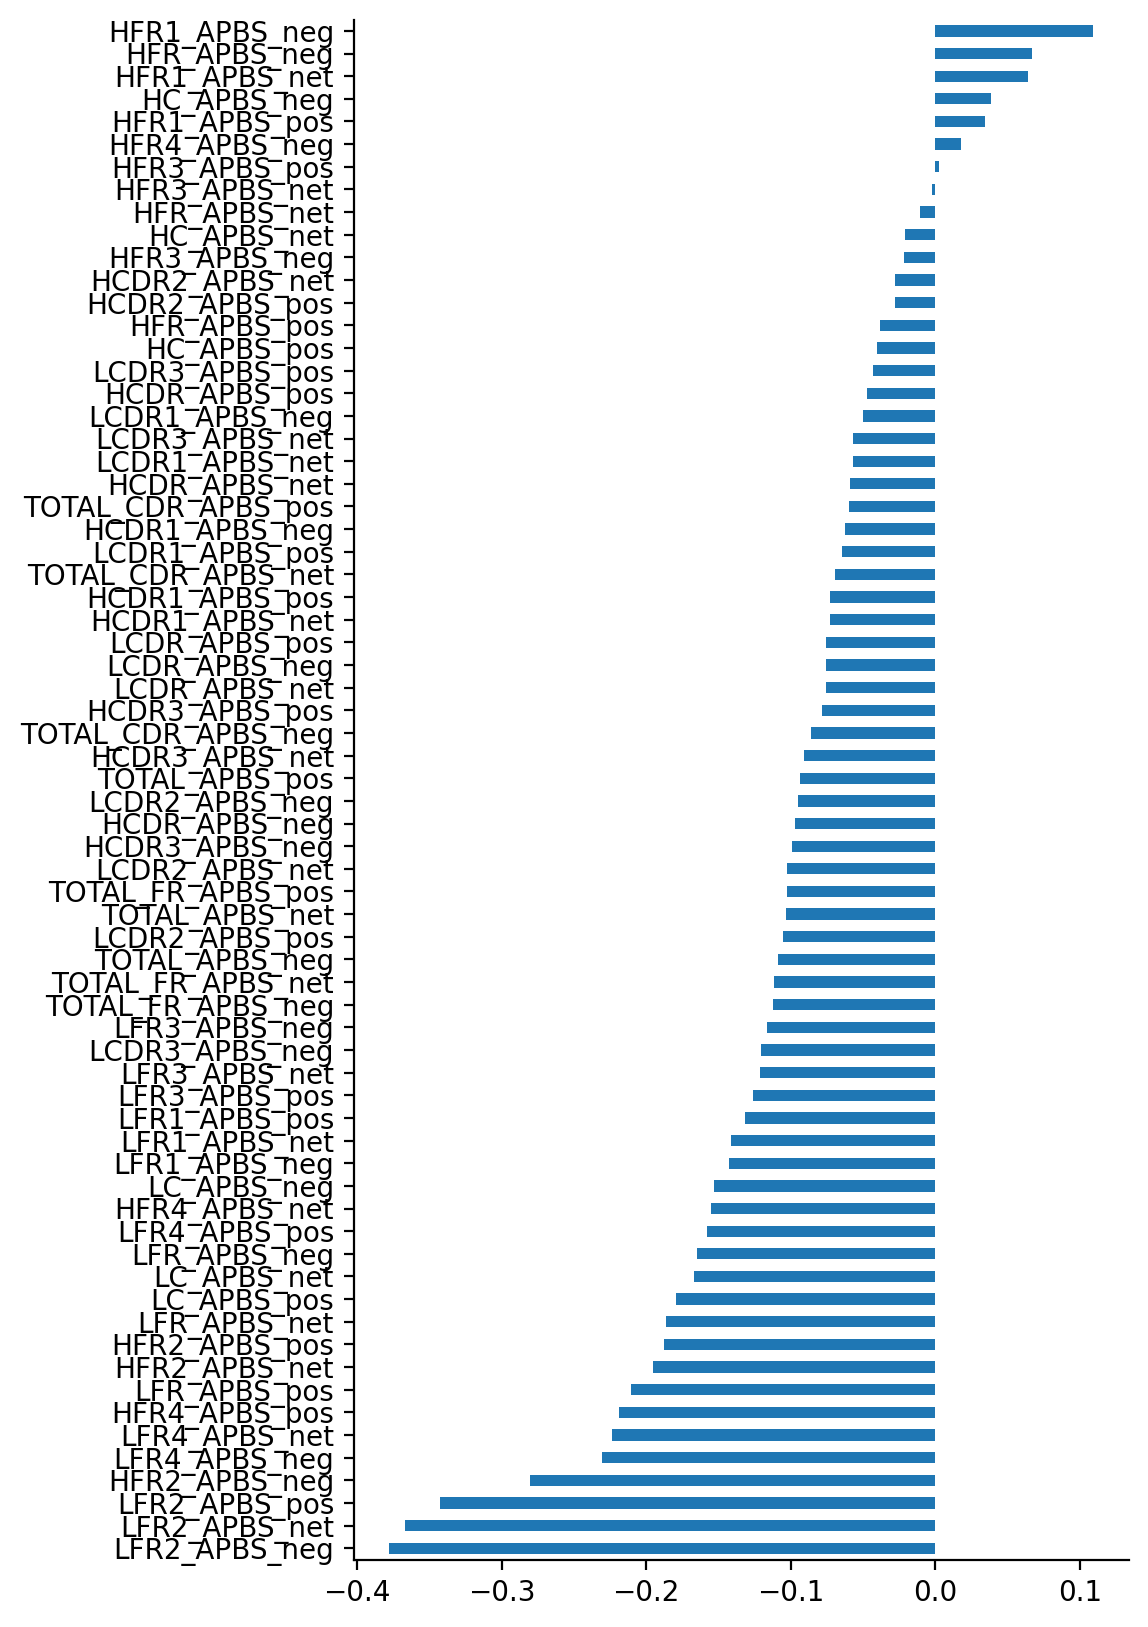

In [21]:
### remove the zeros. 
average_zero = (descriptors_df2==0).mean()
cols = [col for col in average_zero.index if average_zero.loc[col]<0.75]
descriptors_df2 = descriptors_df2[cols]

###
corr2 = descriptors_df2.corr()
heparin_corr2 =corr2.loc['heparin_binding'].sort_values().iloc[:-1]
heparin_corr2.plot(kind='barh', figsize = (5,10))
sns.despine()


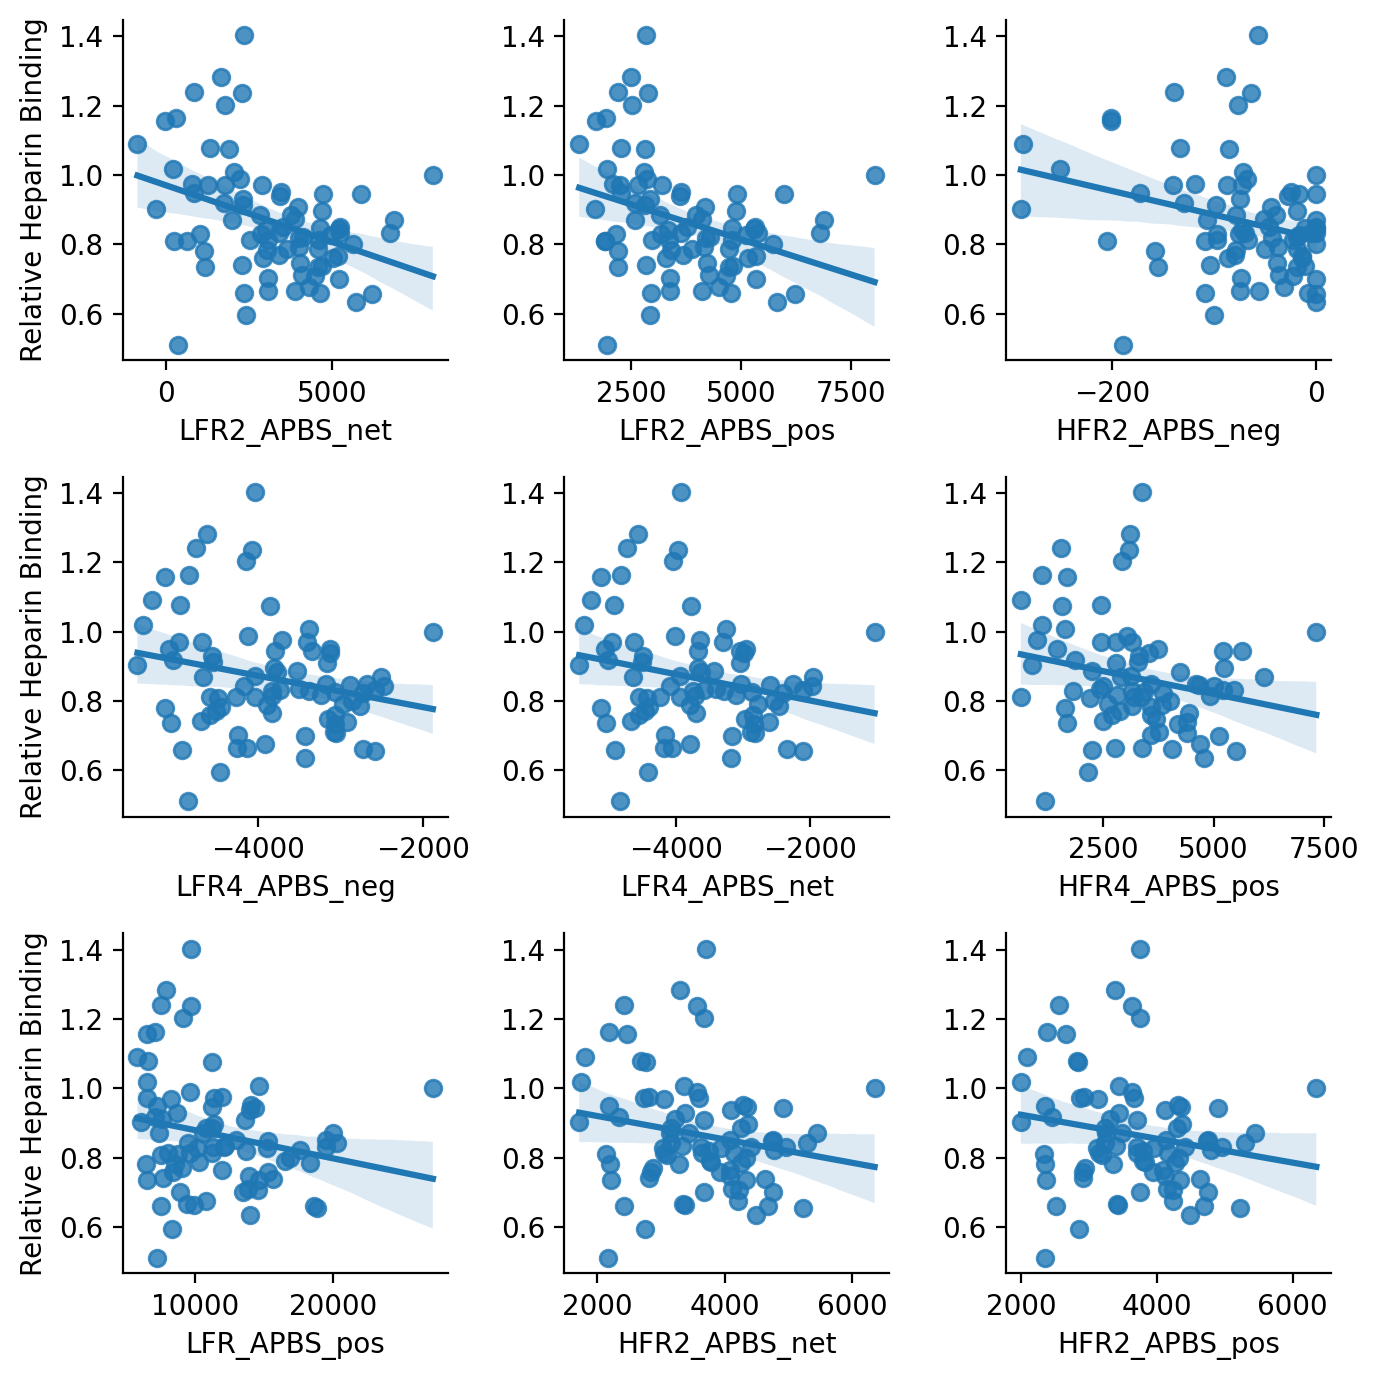

In [22]:
fig, axes = plt.subplots(3,3, figsize = (7,7))
order = np.abs(heparin_corr2).sort_values(ascending=False).index[1:]
axes = np.ravel(axes)
for i in range(9): 
    col = order[i]
    ax = axes[i]
    sns.regplot(data = descriptors_df2, x=col, y= 'heparin_binding', ax = ax)
    if i %3==0:
        ax.set(ylabel = 'Relative Heparin Binding')
    else: 
        ax.set(ylabel = "")
sns.despine()
plt.tight_layout()

#### Combine the two series of heparin correlations for each plate and plot. 

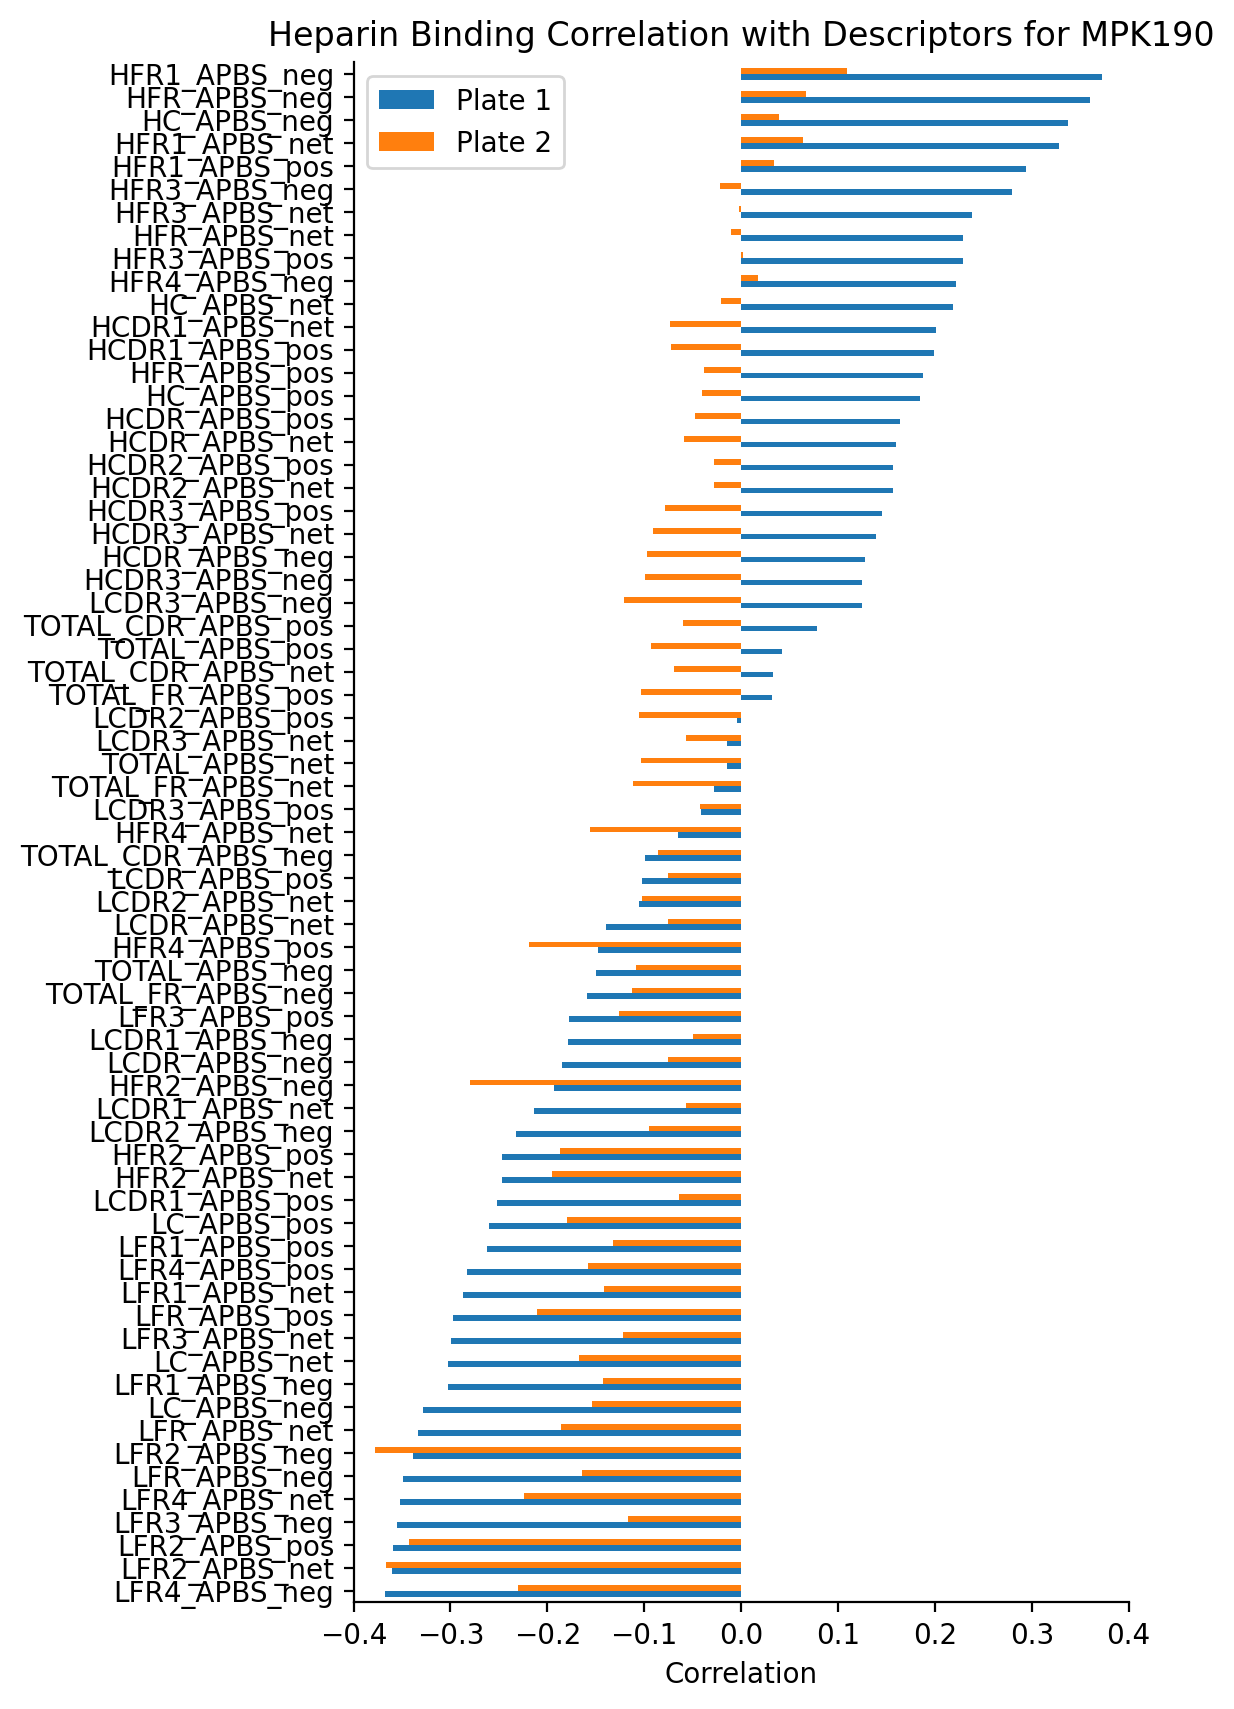

In [23]:
heparin_df = pd.concat([heparin_corr, heparin_corr2], axis = 1).dropna()
heparin_df.columns = ['Plate 1', 'Plate 2']
ax = heparin_df.plot(kind = 'barh', figsize = (5,10))
ax.set(xlabel = 'Correlation', title = 'Heparin Binding Correlation with Descriptors for MPK190', xlim = (-.4, 0.4))
sns.despine()

### Make a scatter plots of the two plates.

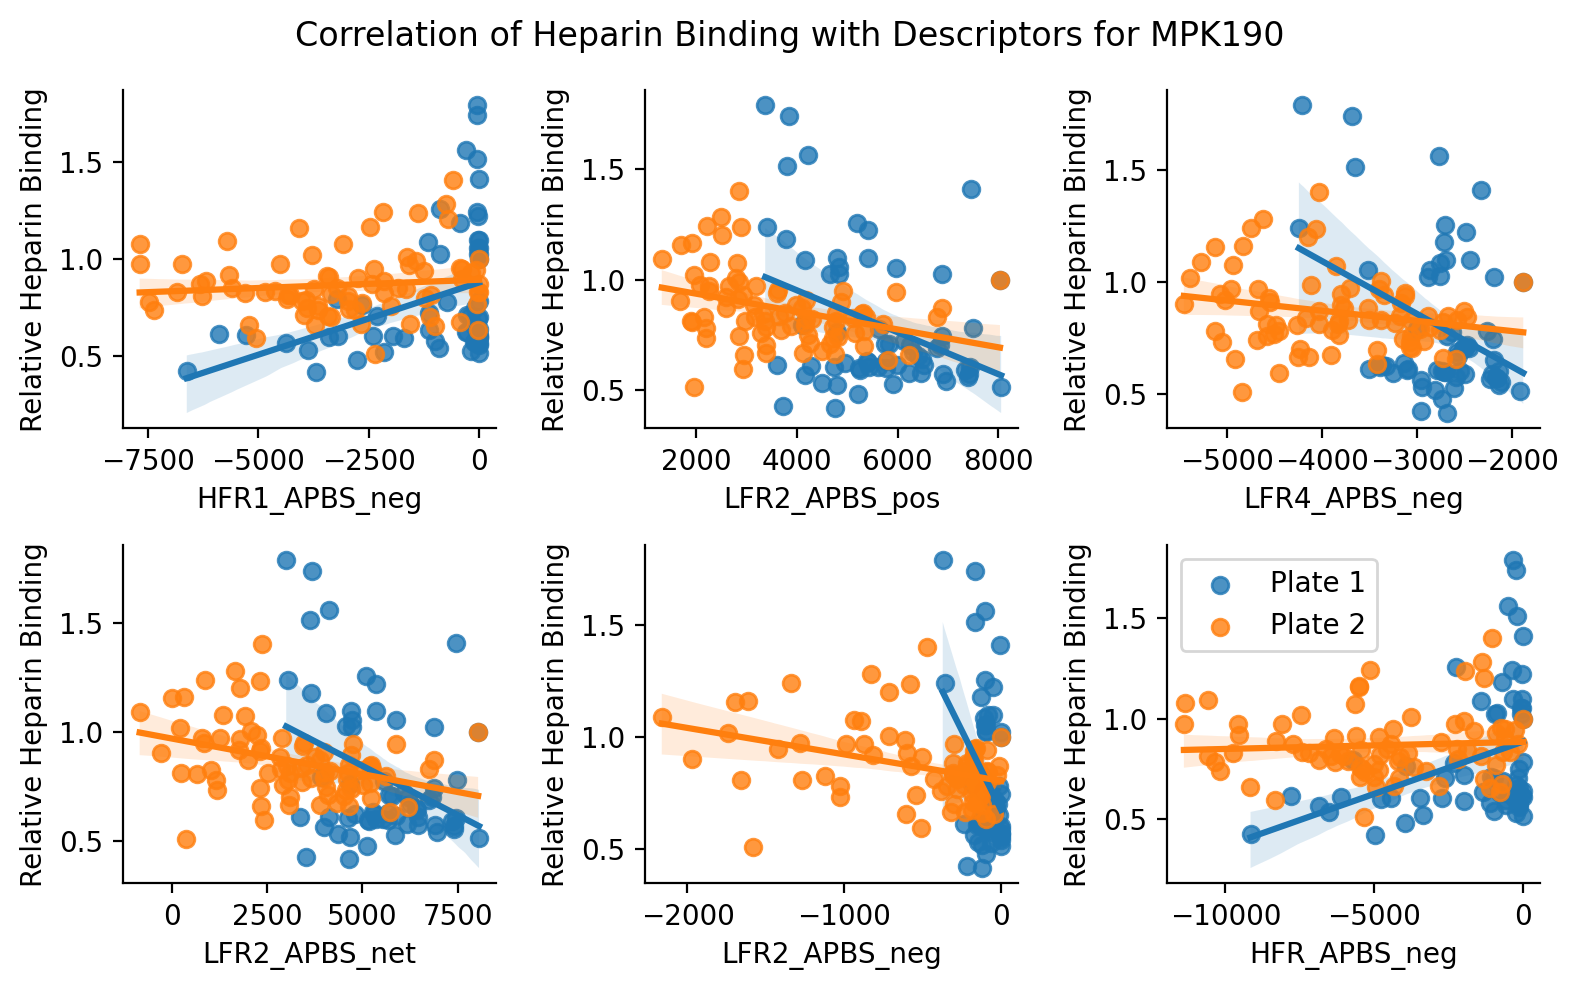

In [24]:
# select the cols with largest magnitude correlation from one of the plates. 
cols= (np.abs(pd.concat([heparin_corr, heparin_corr2]))
        .sort_values(ascending =False).index
        )
selected_cols =set()
number = 6
for col in cols: 
        if col not in selected_cols: 
                selected_cols.add(col)
                if len(selected_cols)==number: 
                        break

fig, axes = plt.subplots(2,3, figsize = (8,5))
axes = np.ravel(axes)
for i, col in enumerate(selected_cols): 
        ax = axes[i]
        sns.regplot(data = descriptors_df, x=col, y= 'heparin_binding', ax = ax, label='Plate 1')

        sns.regplot(data = descriptors_df2, x=col, y= 'heparin_binding', ax = ax, label='Plate 2')
        if i%3==0:
                ax.set(ylabel = 'Relative Heparin Binding')
        ax.set(ylabel = 'Relative Heparin Binding')
        if i==5: 
                ax.legend()

sns.despine()
fig.suptitle('Correlation of Heparin Binding with Descriptors for MPK190')
plt.tight_layout()



### Look at the FATSA file

In [25]:
from Bio import SeqIO
from Bio.SeqUtils import seq1, seq3
from Bio.Align import PairwiseAligner
from abnumber import Chain as AbChain


def get_best_alignments(target, query, n = 10):
    aligner = PairwiseAligner()
    alignments = aligner.align(target, query)
    alignments =[(alignment.score,alignment.counts().gaps, alignment) for alignment in alignments]
    alignments.sort(key = lambda x: x[1])
    return alignments[:n]

fasta = data_path/'MPK190-v1.3-rFab_sequence.fa'
hc, lc = list(SeqIO.parse(fasta, "fasta"))

fvs = extract_sequence_from_pdb(parent_pdb)

chain = AbChain(str(hc.seq), 'kabat', name = 'VH')

### Where are the mutations located? 

In [26]:
def get_mutations(series, mutations=None): 
    if not mutations:
        mutations = {}
    for  row in series: 
        for mut in row: 
            pos = mut[1]
            change = seq3(mut[2])
            mutations.setdefault(pos, [seq3(mut[0]),{}])
            mutations[pos][1].setdefault(change, 0)
            mutations[pos][1][change]+=1

    return mutations

In [27]:
vh_mutations = {}
vl_mutations = {}
for table in [heparin_table, heparin_table2]: 
    vh_mutations = get_mutations(table['Vh mutations'])
    vl_mutations = get_mutations(table['Vl mutations'])

print(vh_mutations)
print(vl_mutations)

{3: ['Gln', {'Glu': 43}], 13: ['Lys', {'Gln': 35}], 76: ['Lys', {'Gln': 39}], 2: ['Val', {'Asp': 32}], 5: ['Val', {'Glu': 51}]}
{43: ['Gly', {'Glu': 23}], 76: ['Ala', {'Ser': 58}], 69: ['Ser', {'Glu': 52}], 17: ['Arg', {'Glu': 47}]}


##### Note that all of the mutations should be in the VH and VL domain. 

In [28]:
def sum_cols(df, keys): 
    def is_valid(col, keys): 
        for key in keys: 
            if key not in col: 
                return False
        else: 
            return True
    
    cols = [col for col in df.columns if is_valid(col,keys)]
    
    return df[cols].sum(axis = 1)


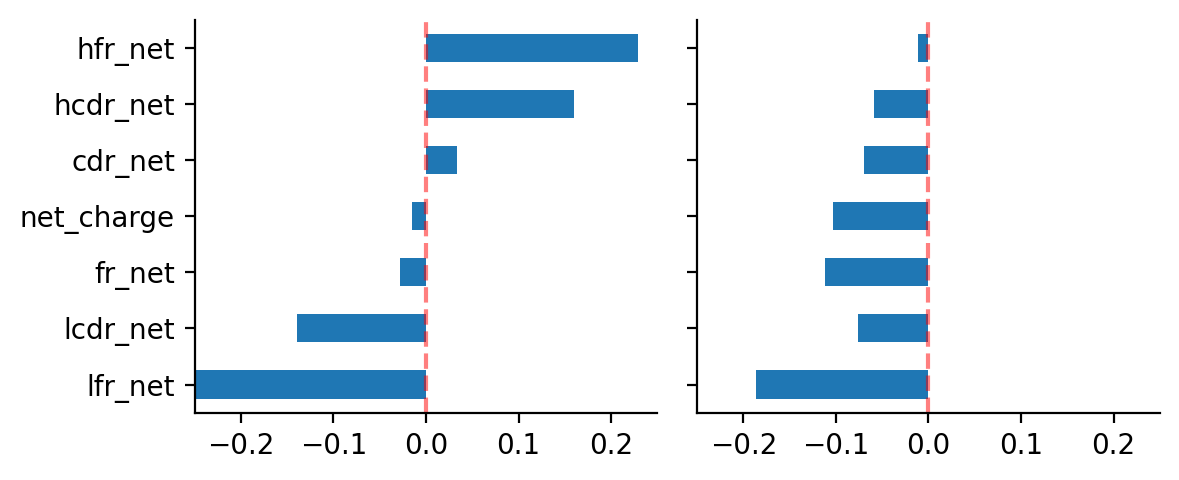

In [29]:
descriptor_sums_df = pd.DataFrame(dict(
    hcdr_net = sum_cols(descriptors_df, keys = ['HCDR', 'net']),
    lcdr_net = sum_cols(descriptors_df, keys = ['LCDR', 'net']),
    cdr_net = sum_cols(descriptors_df, keys = ['CDR', 'net']),
    hfr_net = sum_cols(descriptors_df, keys = ['HFR', 'net']),
    lfr_net = sum_cols(descriptors_df, keys = ['LFR', 'net']),
    fr_net = sum_cols(descriptors_df, keys = ['FR', 'net']),
    net_charge = sum_cols(descriptors_df, keys = ['net'])
))

descriptor_sums_df2 = pd.DataFrame(dict(
    hcdr_net = sum_cols(descriptors_df2, keys = ['HCDR', 'net']),
    lcdr_net = sum_cols(descriptors_df2, keys = ['LCDR', 'net']),
    cdr_net = sum_cols(descriptors_df2, keys = ['CDR', 'net']),
    hfr_net = sum_cols(descriptors_df2, keys = ['HFR', 'net']),
    lfr_net = sum_cols(descriptors_df2, keys = ['LFR', 'net']),
    fr_net = sum_cols(descriptors_df2, keys = ['FR', 'net']),
    net_charge = sum_cols(descriptors_df2, keys = ['net'])
))



heparin_corr_with_sums = descriptor_sums_df.corrwith(descriptors_df['heparin_binding']).sort_values()
heparin_corr_with_sums2= descriptor_sums_df2.corrwith(descriptors_df2['heparin_binding']).sort_values()

order = heparin_corr_with_sums.index

fig, axes = plt.subplots(1,2, figsize = (6, 2.5))


ax = heparin_corr_with_sums[order].plot(kind='barh', ax = axes[0])
ax.set(xlim=(-0.25, 0.25))
ax.axvline(0, linestyle = '--', alpha =0.5, color = 'red')
ax = heparin_corr_with_sums2[order].plot(kind='barh', ax = axes[1])
ax.set(yticklabels='')
ax.set(xlim=(-0.25, 0.25))
ax.axvline(0, linestyle = '--', alpha =0.5, color = 'red')
sns.despine()
plt.tight_layout()


### Plot these versus heparin

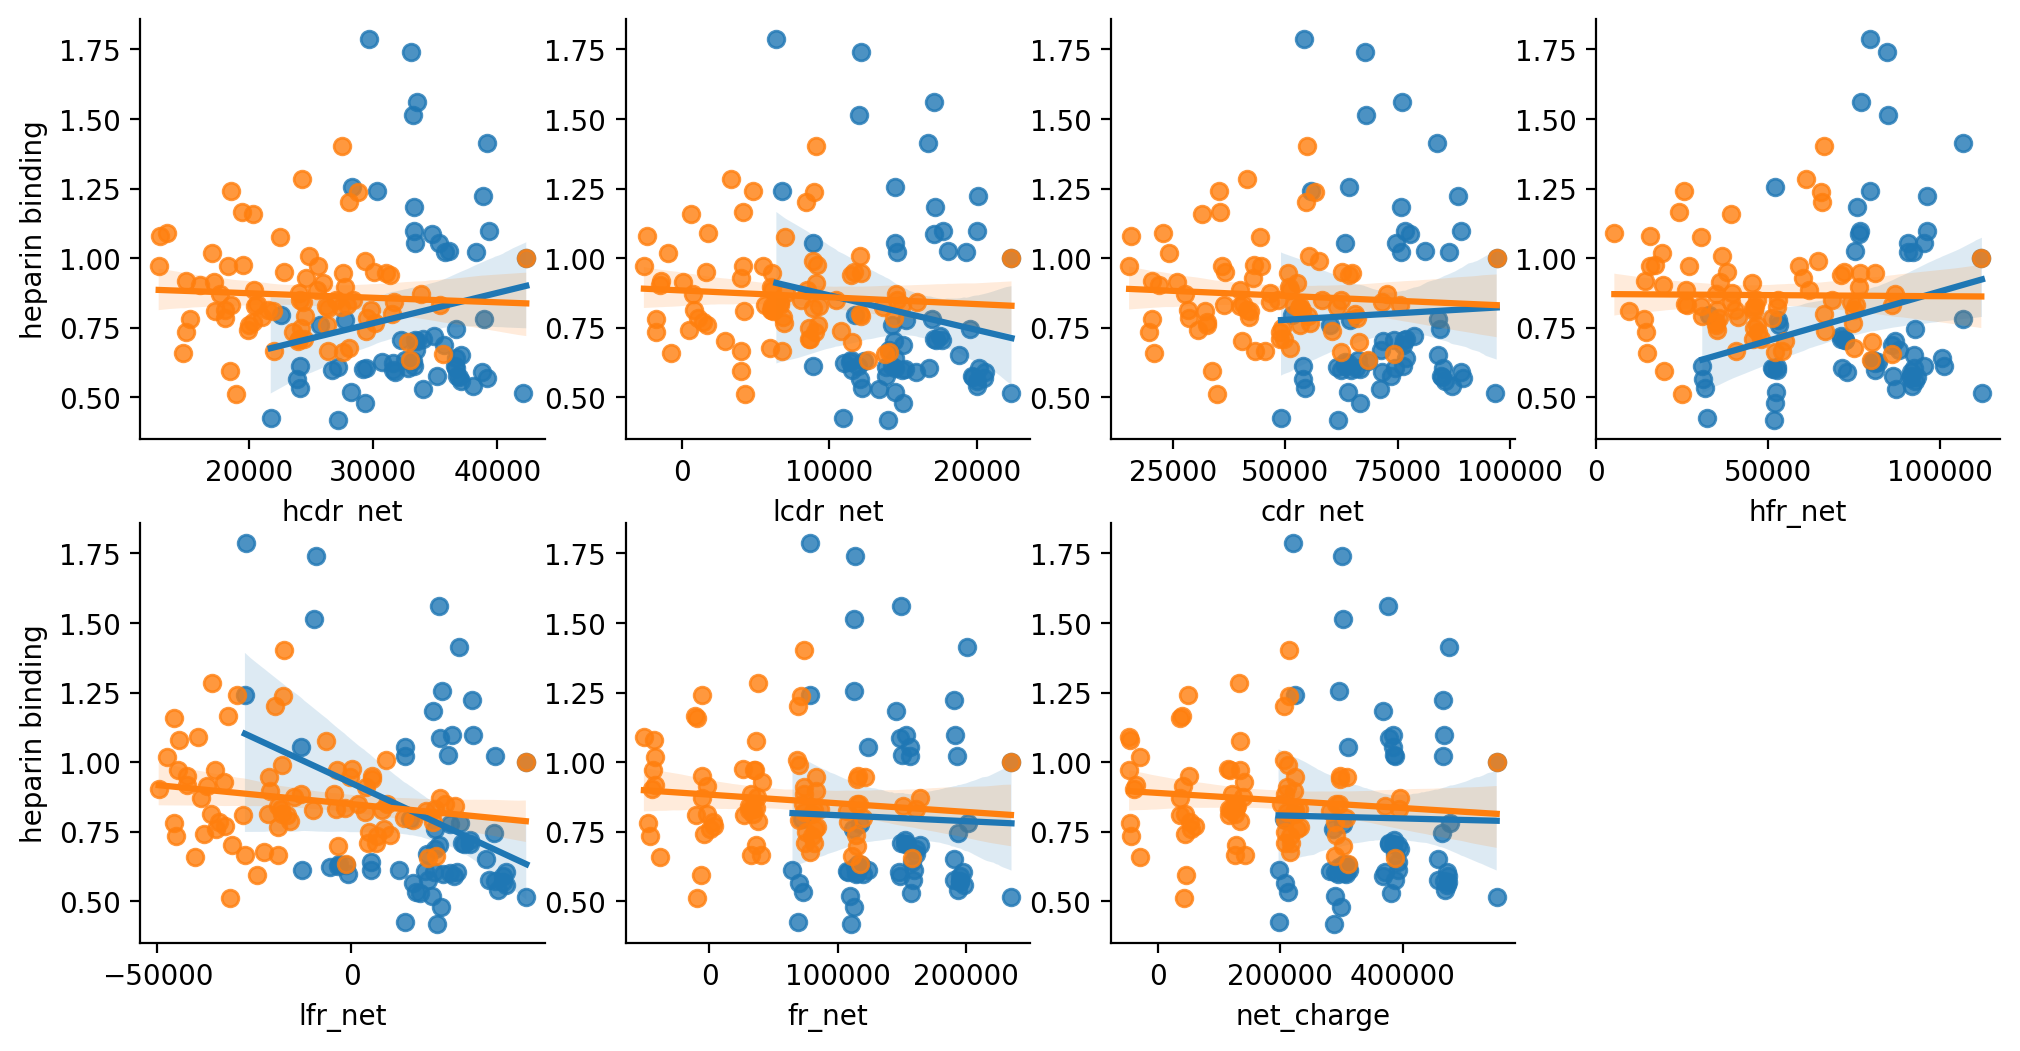

In [30]:
fig, axes = plt.subplots(2,4, figsize = (12,6))
axes = np.ravel(axes)

for i, col  in enumerate(descriptor_sums_df.columns):
    ax = sns.regplot(x =descriptor_sums_df[col], y= heparin_table['heparin binding'], ax =axes[i], label = 'Plate 1')
    ax = sns.regplot(x =descriptor_sums_df2[col], y= heparin_table2['heparin binding'], ax =axes[i], label = 'Plate 2')
    if i%4!=0: 
        ax.set(ylabel="")


axes[7].axis('off')
sns.despine()
    

### Comments: 
Above, we see conflicting results. For the Plate 1, we see decent correlations with increases net (postive) potential and heparin binding. This is expected. However, for the second plate, we fail to se a real relationship (potentially negative).   

##### Add sequences to the heparin tables and save parquet file. 

In [31]:
# reload the fasta 
fasta = data_path/'MPK190-v1.3-rFab_sequence.fa'
hc, lc = list(SeqIO.parse(fasta, "fasta"))

vh = AbChain(str(hc.seq), 'kabat', name = 'VH').seq
vl = AbChain(str(lc.seq), 'kabat', name = 'VL').seq


In [32]:
def mutate_sequence(seq, mutations): 
    seq = list(seq)

    for mutation in mutations: 
        if mutation:
            parent, pos, change = mutation
            pos-=1
            assert seq[pos]==parent
            seq[pos]=change

    return ''.join(seq)


def mutation_list_to_string(mutations): 
    if mutations: 
        return str([f'{m[0]}{m[1]}{m[2]}' for m in mutations])
    else: 
        return ''
            

In [33]:
# first plate
heparin_table['Vl']= [mutate_sequence(vl, mutations) if mutations else vl for mutations in heparin_table['Vl mutations'].values]
heparin_table['Vh'] = [mutate_sequence(vh, mutations) if mutations else vh for mutations in heparin_table['Vh mutations'].values]

heparin_table['plate']= 1

# second plate

heparin_table2['Vl']= [mutate_sequence(vl, mutations) if mutations else vl for mutations in heparin_table2['Vl mutations'].values]
heparin_table2['Vh'] = [mutate_sequence(vh, mutations) if mutations else vh for mutations in heparin_table2['Vh mutations'].values]
heparin_table2['plate']= 2


combined_heparin_table = pd.concat([heparin_table, heparin_table2]).reset_index(drop = True)
combined_heparin_table['Vh mutations'] = combined_heparin_table['Vh mutations'].apply(mutation_list_to_string)
combined_heparin_table['Vl mutations'] = combined_heparin_table['Vl mutations'].apply(mutation_list_to_string)

combined_heparin_table.to_parquet(data_path/'mutations_data.parquet')

### Check to see if some of the mutations are present on both plates. 
Cyrus suggested that I do this. I agree. 
Actually there are no overlaps as seen below. 

In [34]:
def name_mutation(row): 
    
    vh = row['Vh mutations']
    vl = row['Vl mutations']

    name ='MPK190'
    if vh: 
        vh = '_'.join(vh[1:-1].replace("'",'').replace(' ', '').split(','))
        name += f'_VH_{vh}'

    if vl: 
        vl = '_'.join(vl[1:-1].replace("'",'').replace(' ', '').split(','))
        name += f'_VL_{vl}'

    return name

combined_heparin_table['Name'] = combined_heparin_table.apply(name_mutation, axis = 1)



combined_heparin_table['Name'].value_counts().value_counts()

count
1    140
2      1
Name: count, dtype: int64

### Remarks: 
Above, I did the following:
1. Wrote code using PDB Fixer to introduce mutations into the parental AB starting from the PDB file. 
2. Extracted descriptors from it. 
3. Looked at the correlation between heparin binding as measured by ELISA and the descriptors. 
4. Compared results between two plates. 

#### Conclustions/CLosing remarks.
Despite seeing good results from the descriptors on the therapeutic antibody, we failed to see excellent correlations we expect between Heparin binding (ELISA) and the calculated descriptors. This was likely due to experimental error for the ELISA assay as it is still being developed. It could be also due to the method of introducing mutations. I am exploring this next. 

### Plot correlogram 

In [35]:
combinded_descriptors_df = pd.concat([descriptors_df, descriptors_df2]).reset_index(drop = True).drop('heparin_binding', axis = 1)
corr = (combinded_descriptors_df.corr()
        .dropna(axis = 1, how = 'all')
        .dropna(axis = 0, how = 'all')
        )

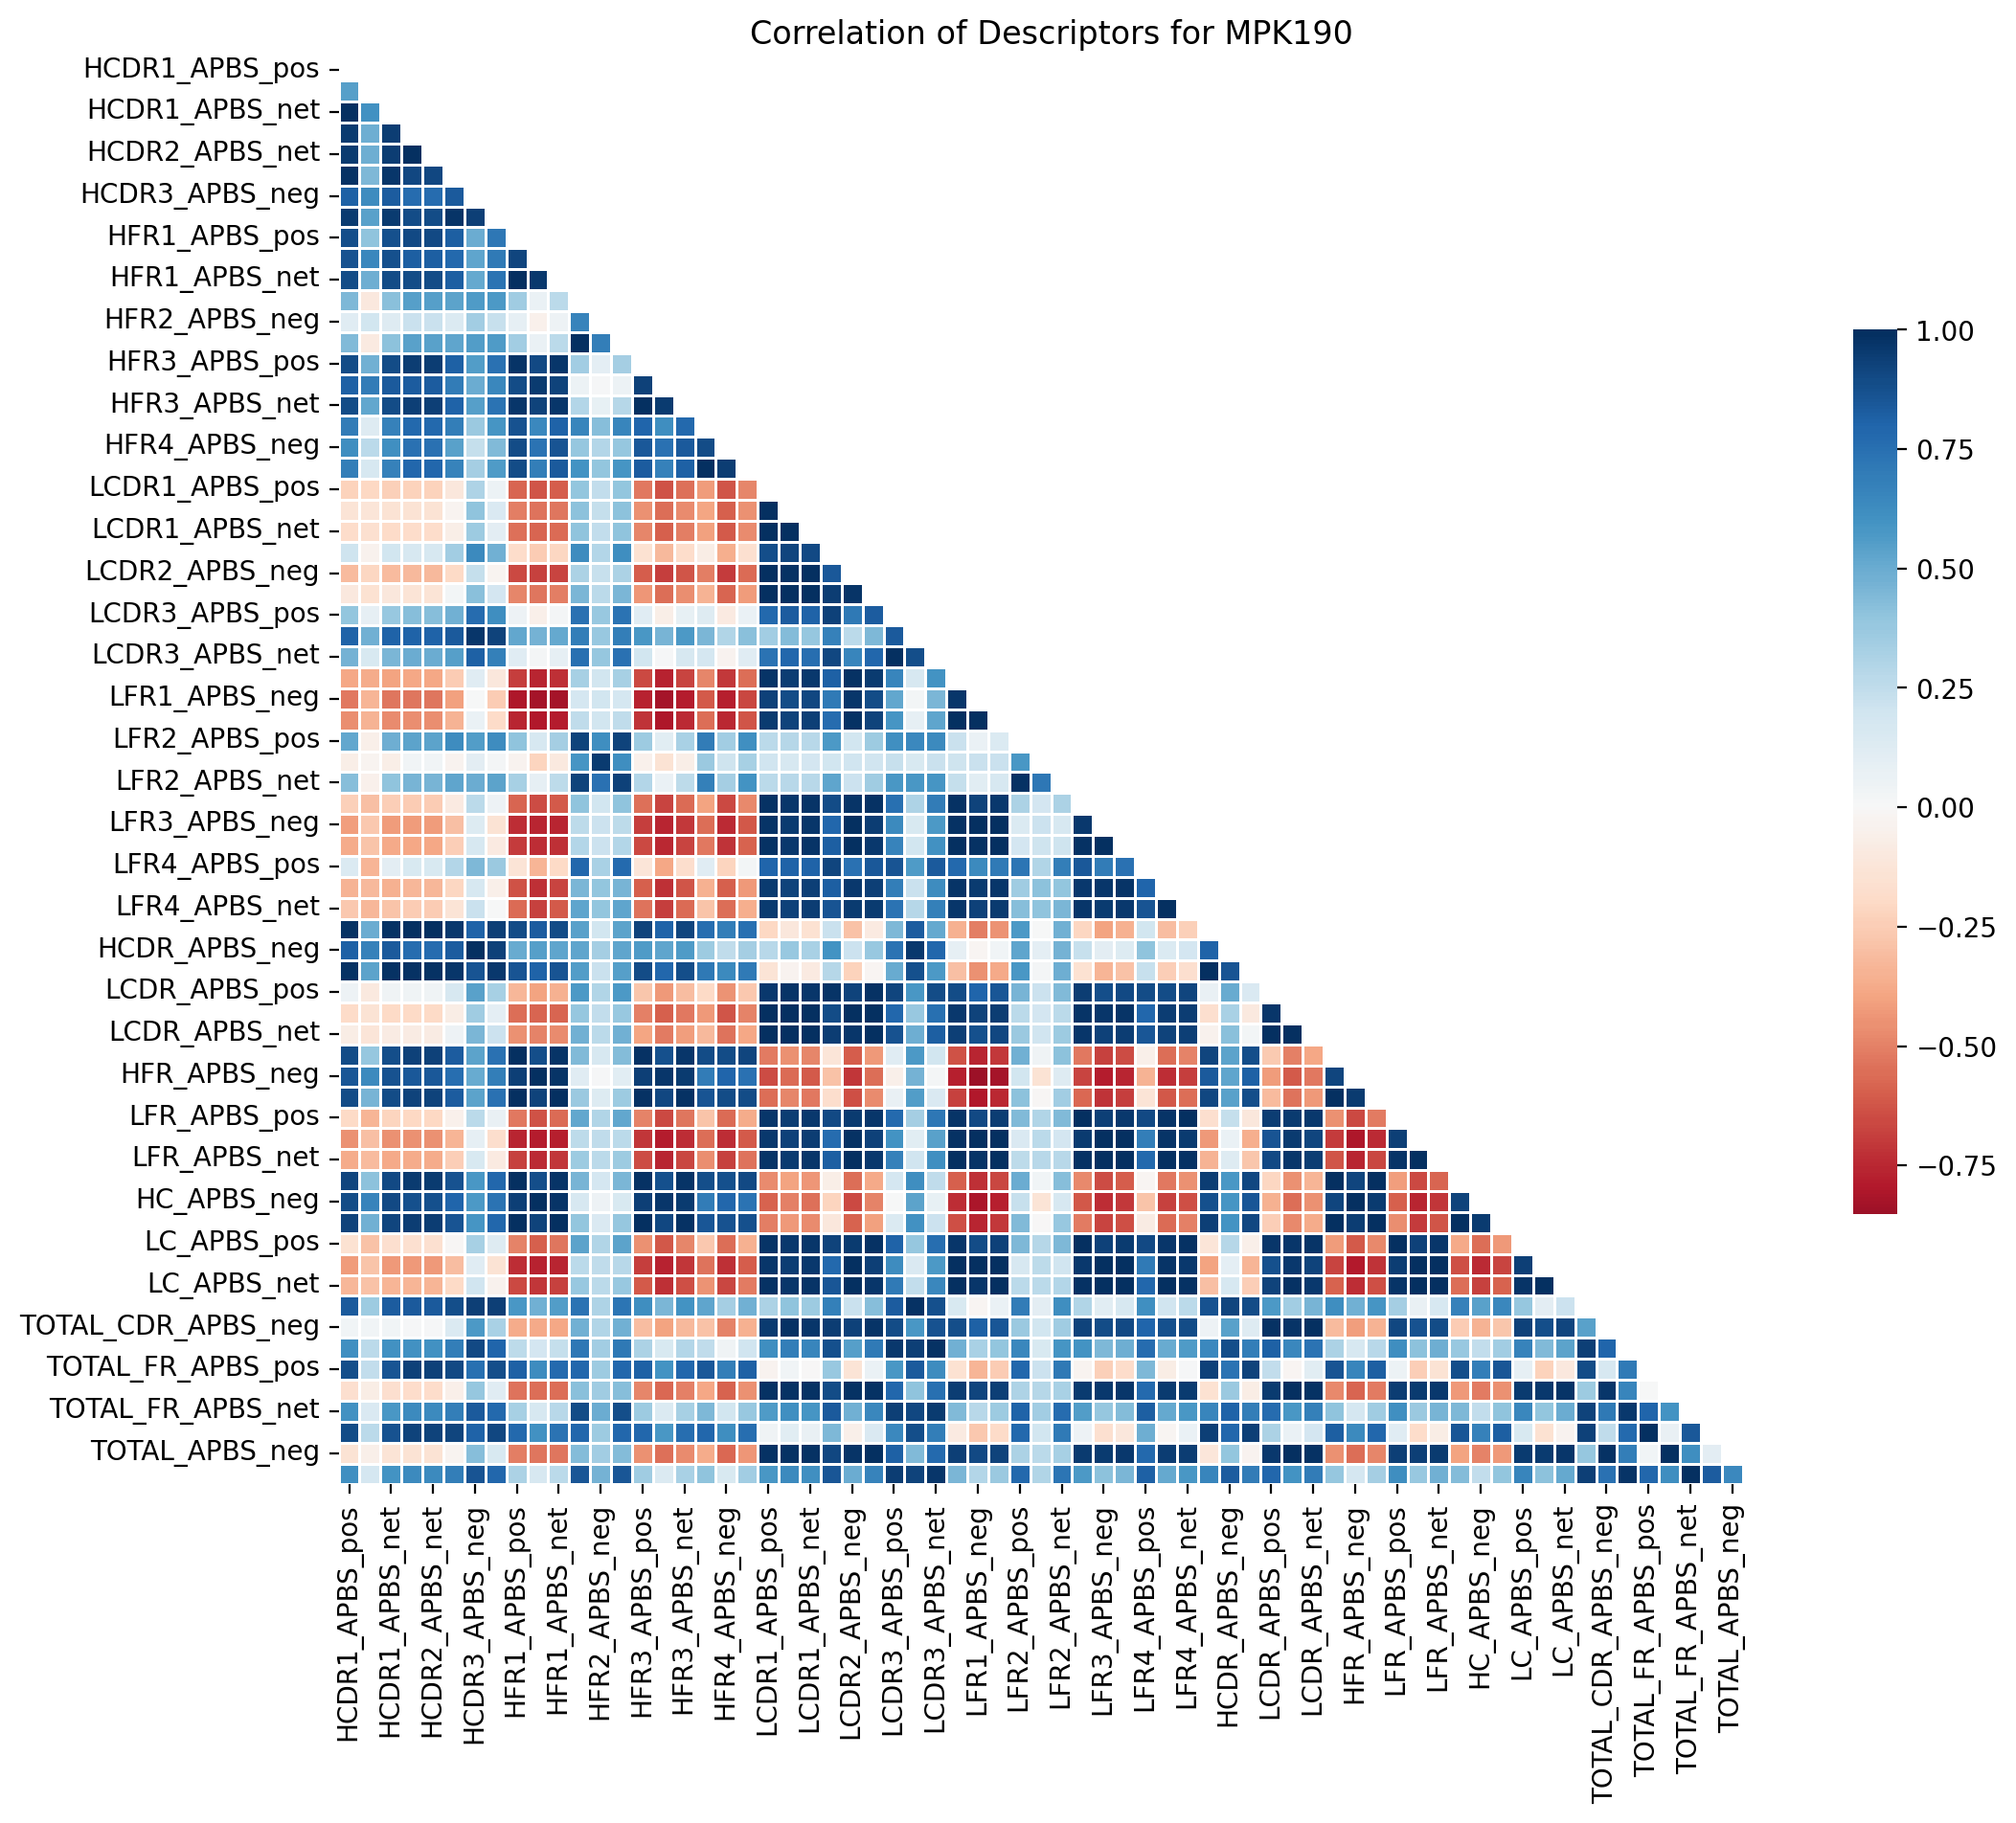

In [36]:
from developability.utils import plot_correlogram
plot_correlogram(corr, figsize = (12,12), title = 'Correlation of Descriptors for MPK190', cmap = 'RdBu')

#### Plot a heatmap showing values of the descriptors for each mutation.

<Axes: >

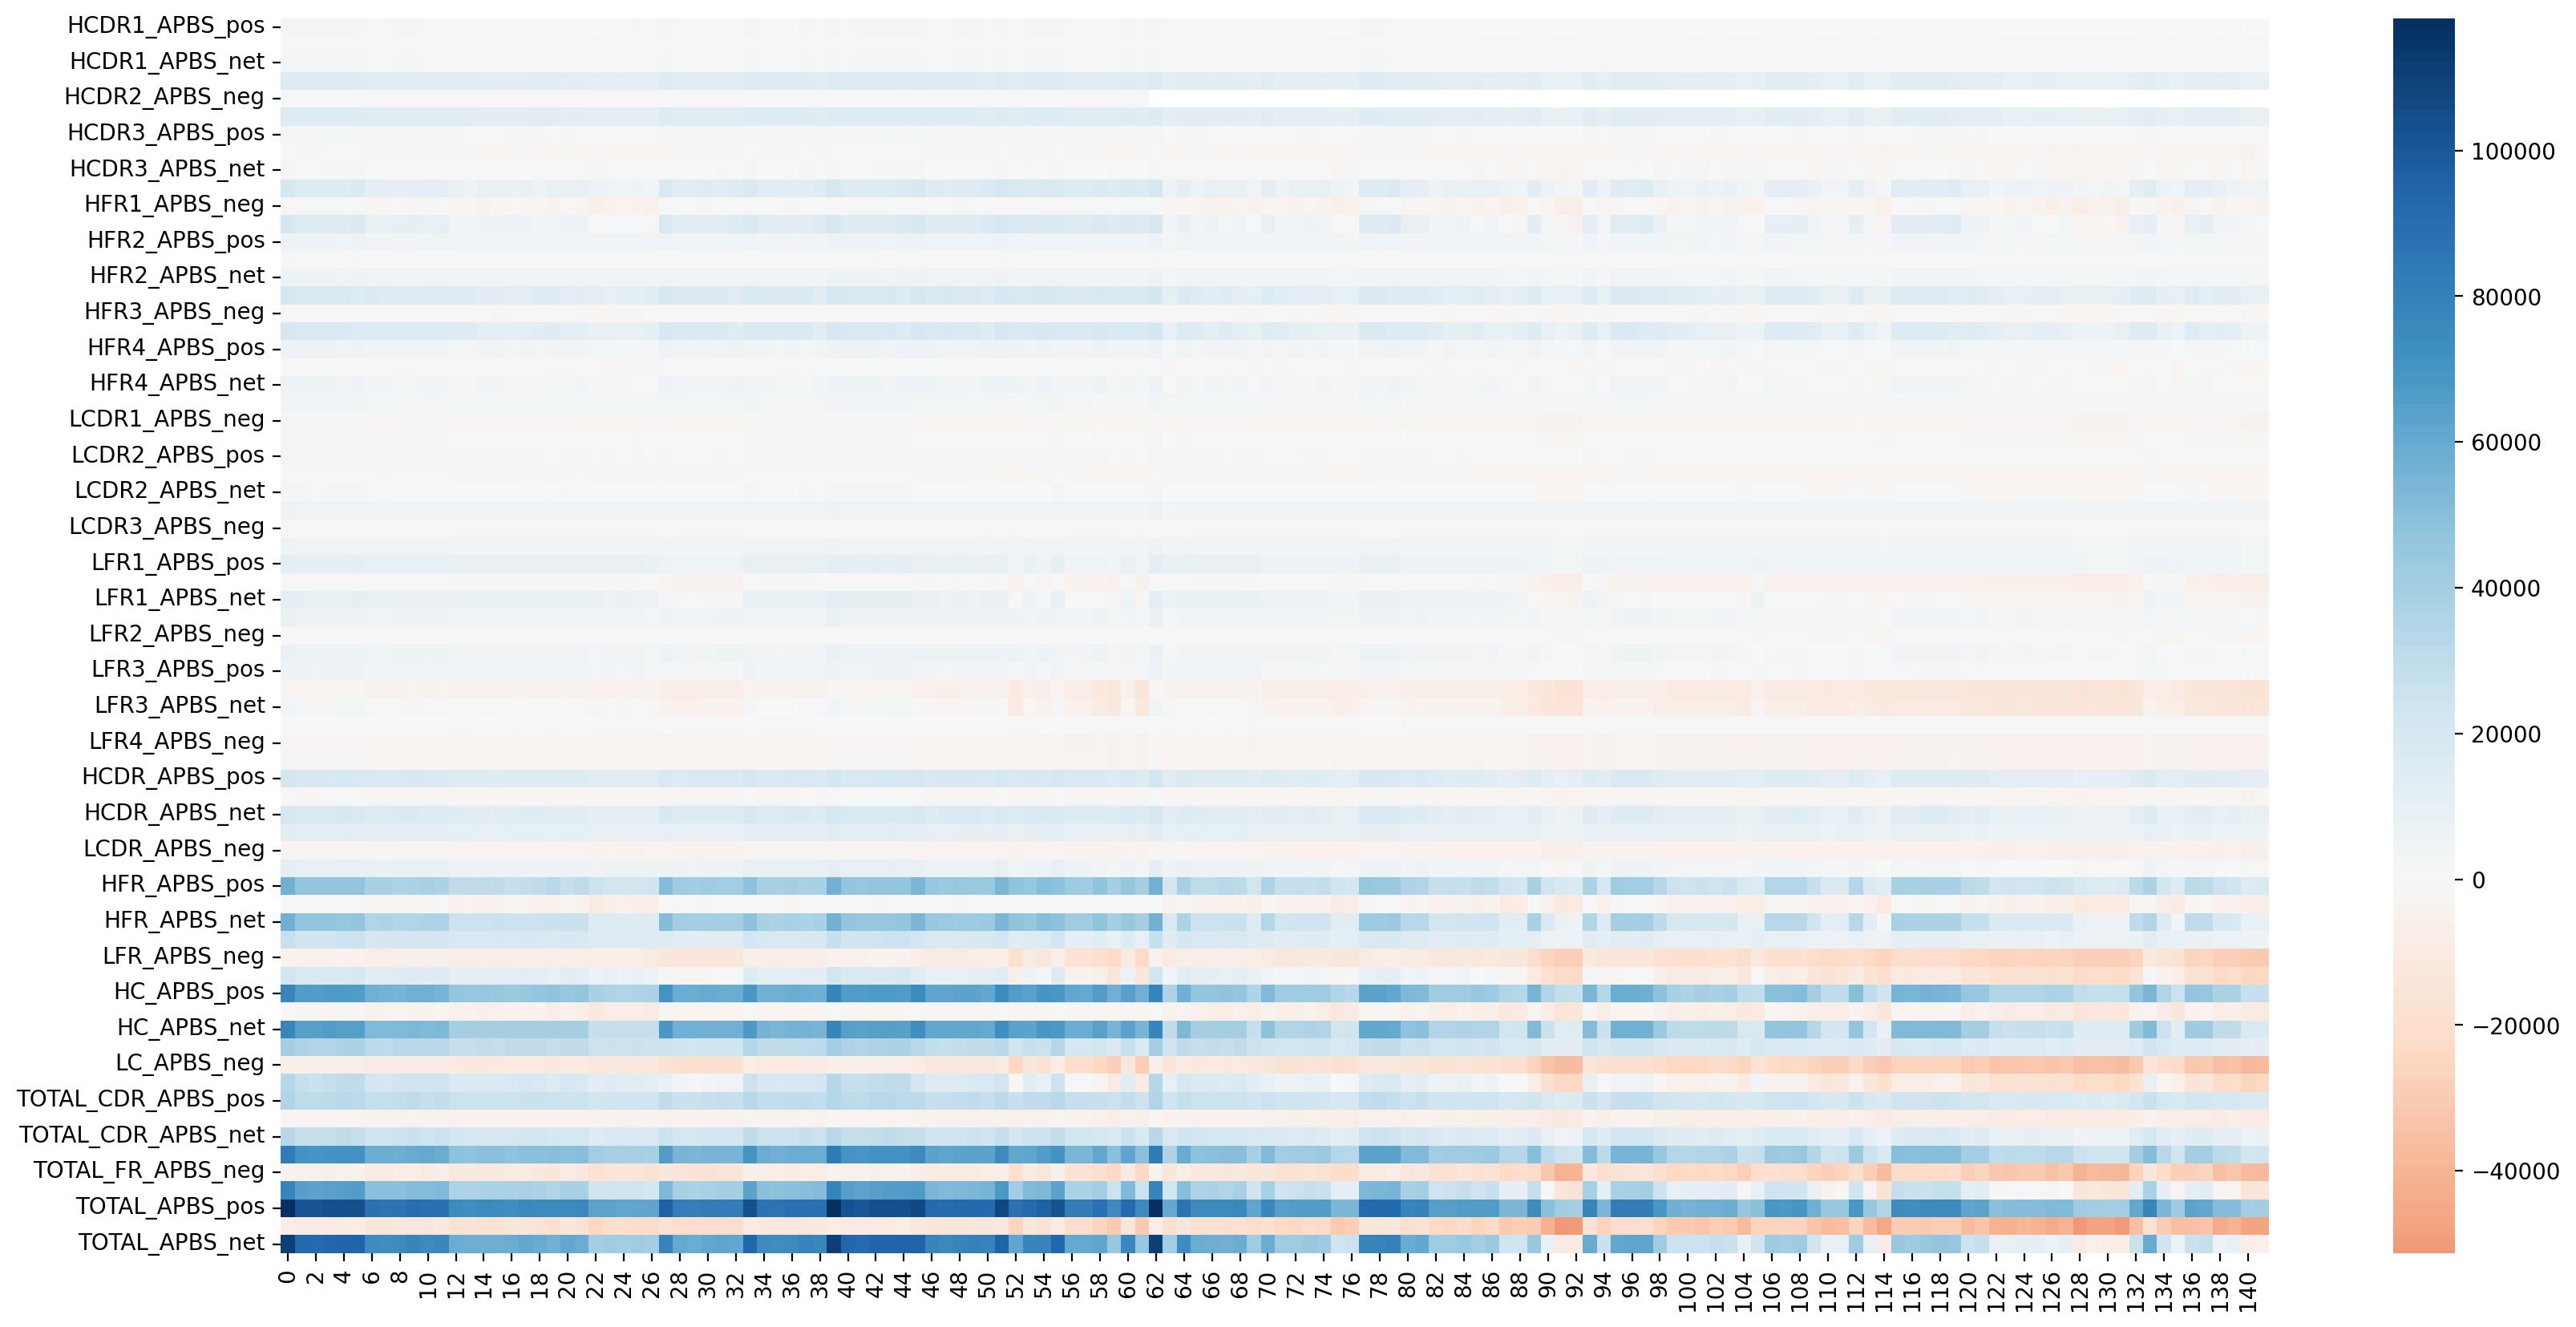

In [37]:
fig, axes = plt.subplots(1,1, figsize = (20,10))
sns.heatmap(combinded_descriptors_df.T, cmap = 'RdBu', center = 0, ax = axes)

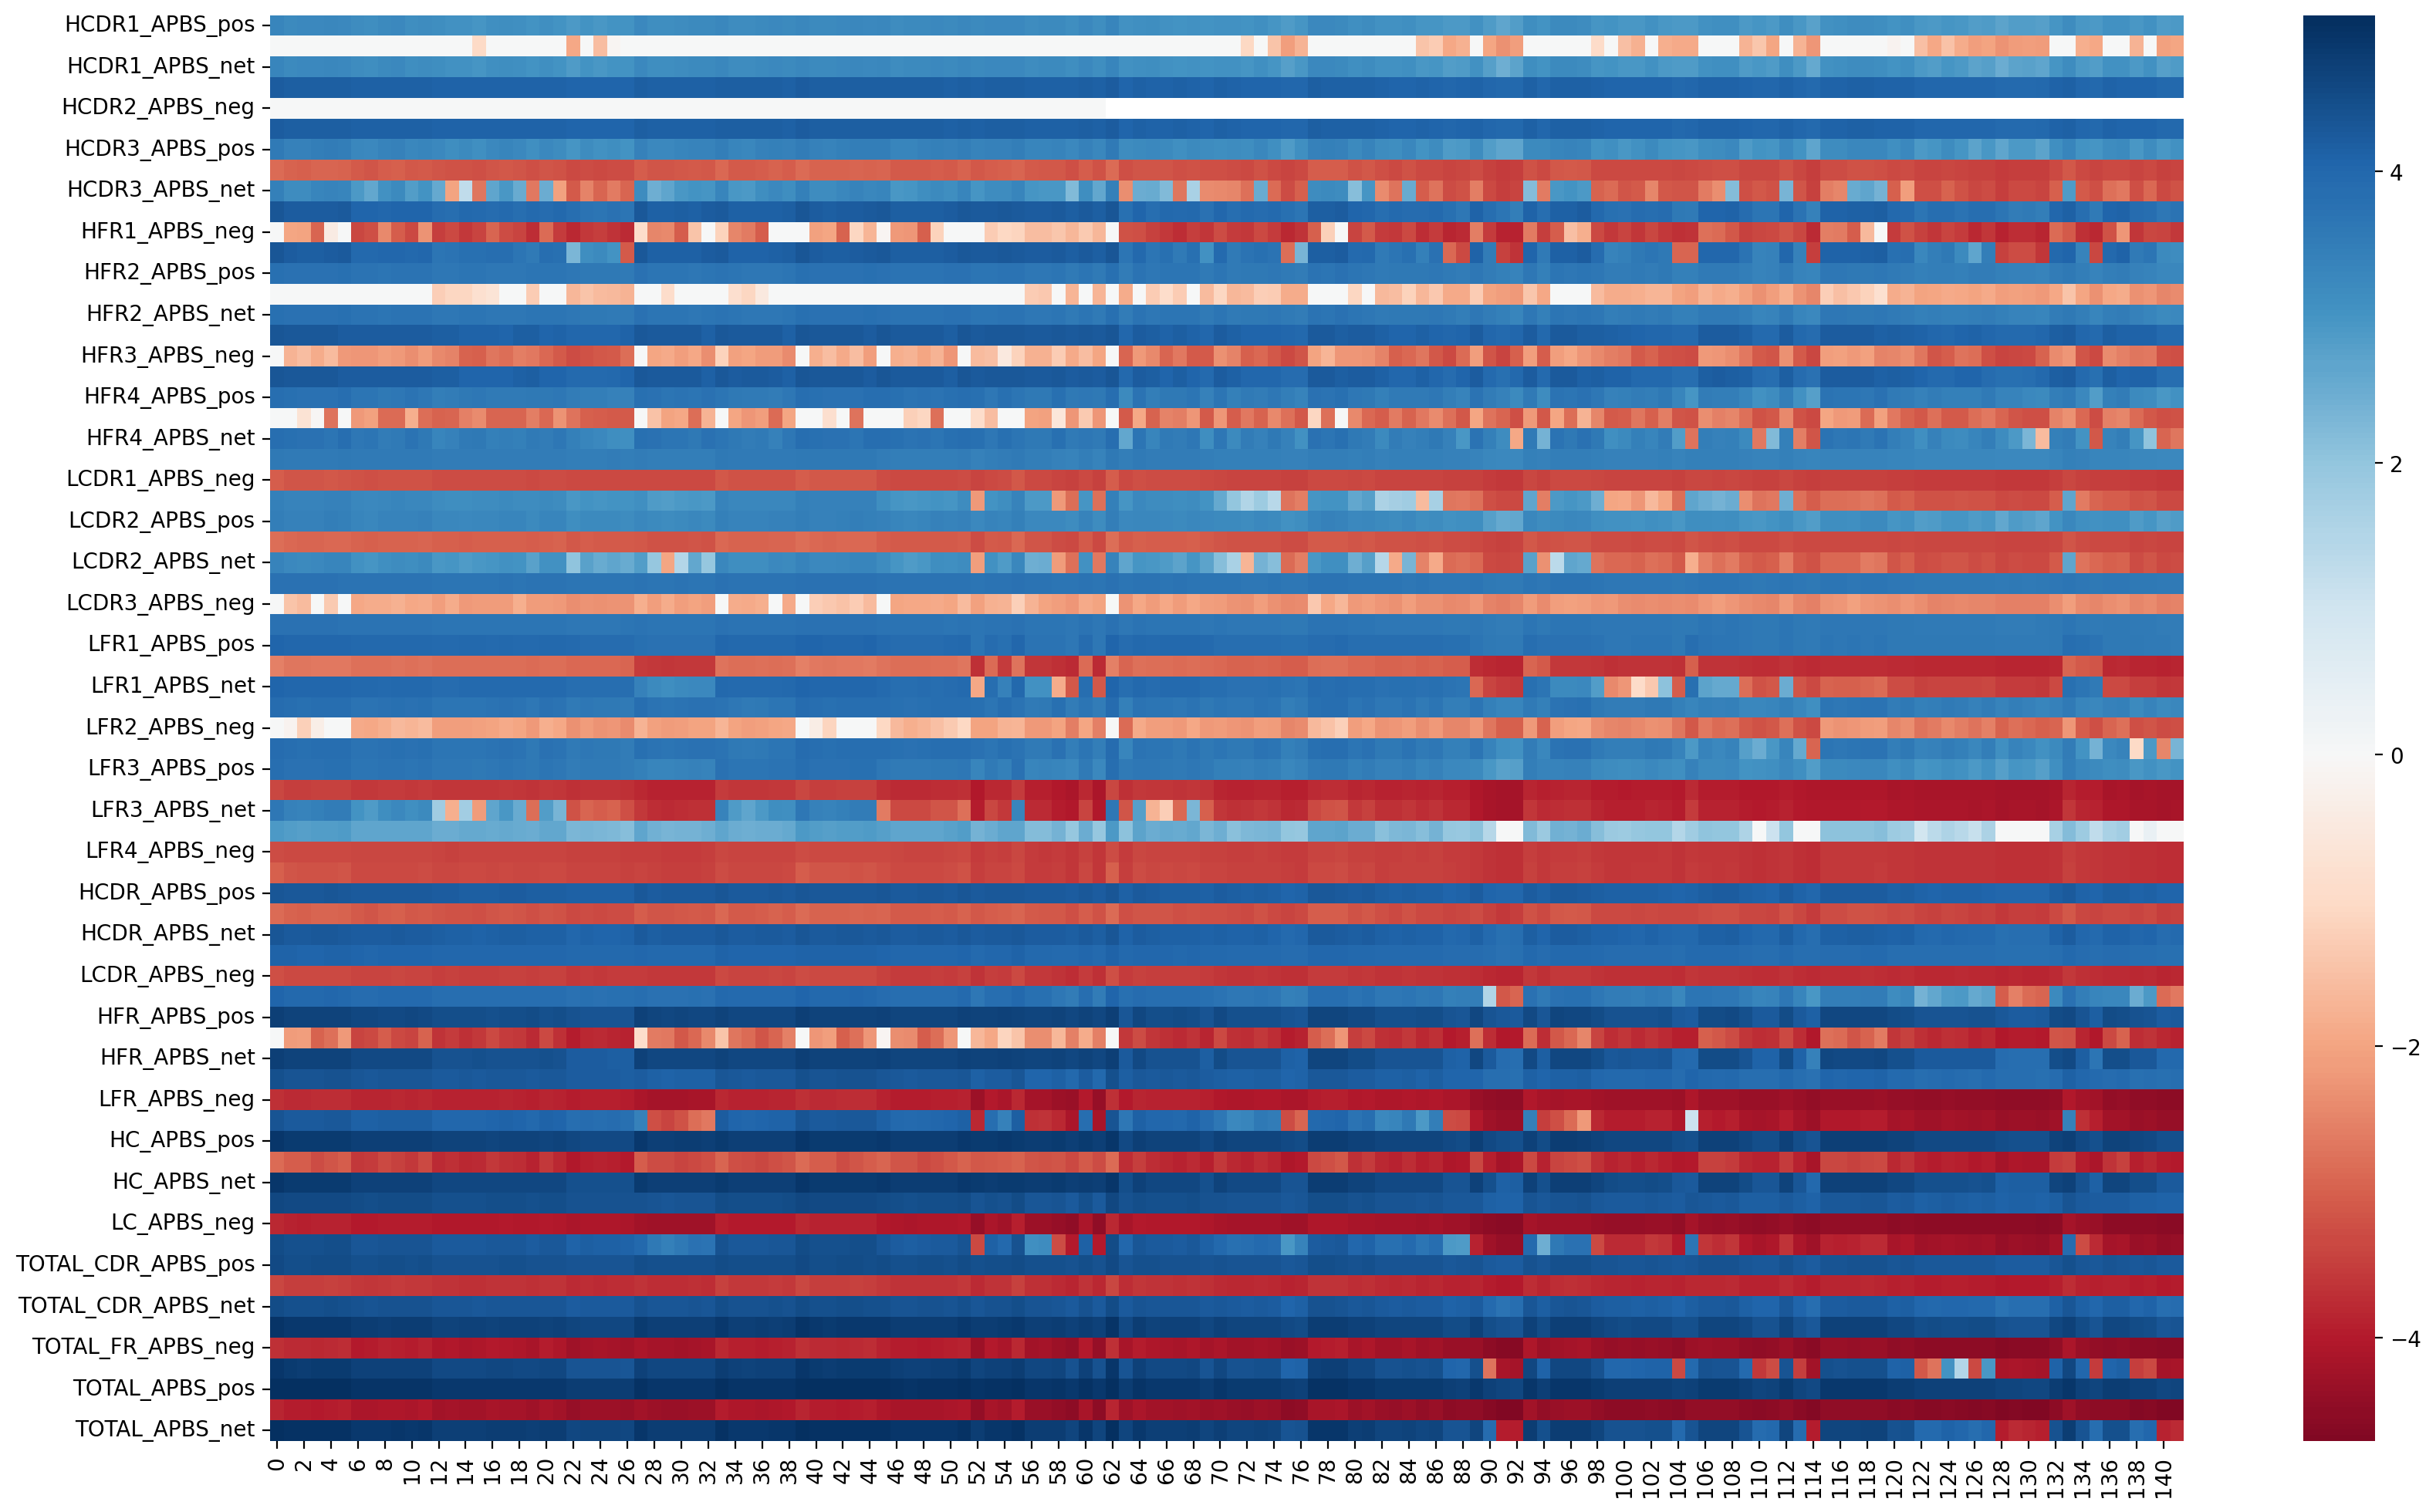

In [38]:
fig, axes = plt.subplots(1,1, figsize = (20,12))
signed_log10 = np.sign(combinded_descriptors_df)*np.log10(np.abs(combinded_descriptors_df)+1)

sns.heatmap(signed_log10.T, cmap = 'RdBu', center = 0, ax = axes);

### Recalculate the descriptors

In [39]:
def recalculate_descriptors(directory):
    from developability.utils import determine_chain_type
    from developability.descriptors import descriptor_pipeline
    from developability.pdb_tools import extract_sequence_from_pdb

    descriptors = []
    output_dirs = [d for d in ls(directory) if d.is_dir() and d.name.endswith('_output')]
    for output_dir in tqdm(output_dirs): 
        residue_pot_file = output_dir/'residue_potential.csv'
        antibody_name = output_dir.name.split('_')[0]
        input_pdb = directory/f'{antibody_name}.pdb'
        

        # get the sequence from the input pdb
        sequences = extract_sequence_from_pdb(input_pdb)
        light_chain_seq , heavy_chain_seq = determine_chain_type(sequences)

        # Calculate the descriptors
        descriptors.append(descriptor_pipeline(light_chain_seq, heavy_chain_seq,residue_pot_file, antibody_name))
    
    descriptors_df = pd.concat(descriptors)
    return descriptors_df
    


    

I used the code below to recalculate the descriptors for these mutants and save them. 

```python

directory = base_output_path
ds = recalculate_descriptors(directory)

descriptors_fname = data_path/'MPK190_antibodies_sheet1_descriptors.pq'
descriptors_df =pd.read_parquet(descriptors_fname)

ds.loc[ds.index.isin(descriptors_df.index)].to_parquet(descriptors_fname)

descriptors_fname2 = data_path/'MPK190_antibodies_sheet2_descriptors.pq'
descriptors_df2 =pd.read_parquet(descriptors_fname2)

ds.loc[ds.index.isin(descriptors_df2.index)].to_parquet(descriptors_fname2)
```